# TSA PROJECT - FORECAST WITH VECM AND ARIMA MODELS

Project description:

The aim of the project is to compare accuracy of forecasts of prices of two cointegrated financial
instruments with VECM model and two independent univariate ARIMA models.
In order to accomplish the task you should:
    • Download the provided TSA_2025_project_data_1.csv file with time series including prices of ten
    financial instruments.
    • Find one cointegrated pair out of ten provided time series. There is more than one cointegrated
    pair but you are supposed to find just one of them. If you found more than one pair, you can
    choose any of them for further analysis.
    • Build a bivariate VECM model for the identified pair and produce forecasts of prices of two
    instruments for the out-of-sample period.
    • Find separately for two instruments the most attractive univariate ARIMA models and produce
    forecasts for the same out-of-sample period.
    • Compare accuracy of forecasts of the prices using the ex-post forecast error measures.
    • Prepare a short report on it.

## Preparation of data and global settings

In [5]:
# Loading dependencies
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from scipy.stats import norm
from statsmodels.stats.stattools import jarque_bera

from IPython.display import Markdown

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [67]:
#Importing dataset
df = pd.read_csv("TSA_2025_project_data_1.csv") 

In [3]:
df.head()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,119.3200000000
1,2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,119.3600000000
2,2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,119.3800000000
3,2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,121.0600000000
4,2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,122.1700000000


In [4]:
df.tail()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
595,2025-04-26,236.2500000000,157.4300000000,98.5300000000,187.4200000000,104.9200000000,70.5900000000,38.8800000000,86.8000000000,136.4900000000,215.3200000000
596,2025-04-27,235.2600000000,159.6600000000,100.2400000000,187.0900000000,104.5100000000,69.5400000000,30.5500000000,89.8800000000,131.3800000000,220.0300000000
597,2025-04-28,235.0700000000,162.0400000000,102.2700000000,187.4000000000,104.0300000000,68.7200000000,38.7200000000,93.0900000000,129.8600000000,224.6000000000
598,2025-04-29,234.9900000000,164.3900000000,103.1700000000,186.8800000000,103.3400000000,67.4100000000,44.0100000000,94.2400000000,128.1600000000,229.3100000000
599,2025-04-30,234.7000000000,167.0500000000,105.4500000000,186.7600000000,102.9000000000,66.3600000000,53.7500000000,98.2600000000,132.4900000000,234.8700000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   y1      600 non-null    float64
 2   y2      600 non-null    float64
 3   y3      600 non-null    float64
 4   y4      600 non-null    float64
 5   y5      600 non-null    float64
 6   y6      600 non-null    float64
 7   y7      600 non-null    float64
 8   y8      600 non-null    float64
 9   y9      600 non-null    float64
 10  y10     600 non-null    float64
dtypes: float64(10), object(1)
memory usage: 51.7+ KB


In [68]:
# Convert the `date` column to datetime
df['date'] = pd.to_datetime(df['date'])
print(df.info())

# Set the `date` column as the index
df.set_index('date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    600 non-null    datetime64[ns]
 1   y1      600 non-null    float64       
 2   y2      600 non-null    float64       
 3   y3      600 non-null    float64       
 4   y4      600 non-null    float64       
 5   y5      600 non-null    float64       
 6   y6      600 non-null    float64       
 7   y7      600 non-null    float64       
 8   y8      600 non-null    float64       
 9   y9      600 non-null    float64       
 10  y10     600 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 51.7 KB
None


In [69]:
# Creation of shorter sample by excluding last 25 observations (OOS)
forecast_horizon = 25
df_in_sample = df.iloc[:-forecast_horizon]

In [8]:
df_in_sample

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,119.3200000000
2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,119.3600000000
2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,119.3800000000
2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,121.0600000000
2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,122.1700000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-01,224.1200000000,166.0000000000,82.2000000000,181.8800000000,112.3600000000,85.4100000000,67.0800000000,60.9000000000,161.1700000000,232.5900000000
2025-04-02,222.0700000000,165.7500000000,82.1600000000,180.9900000000,112.8400000000,86.4800000000,63.8100000000,61.0000000000,164.5500000000,232.0900000000
2025-04-03,219.1900000000,164.1600000000,81.6600000000,179.8500000000,113.1300000000,87.4500000000,61.4400000000,60.1900000000,166.9800000000,228.8800000000


## Finding a cointegrated variables

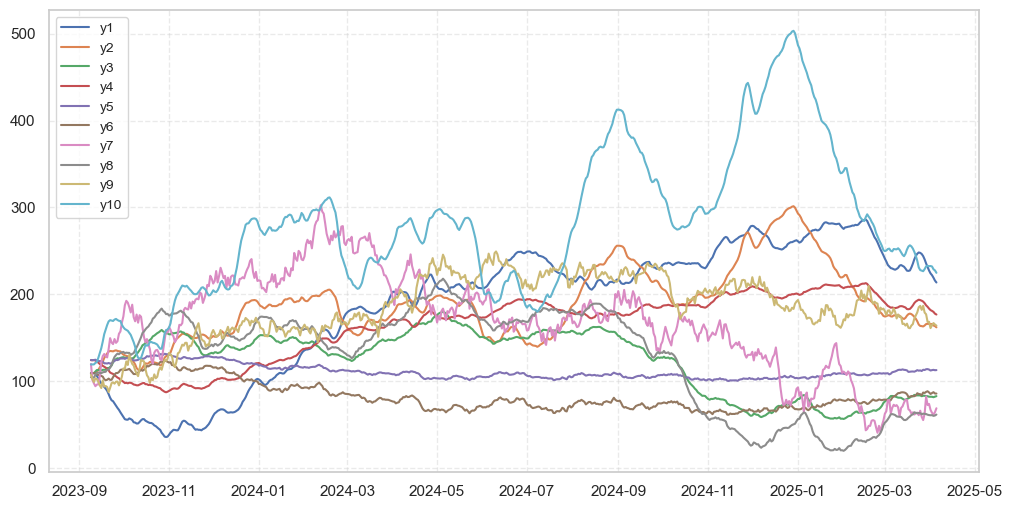

In [12]:
#Plot of variables in dataset
plt.figure(figsize=(12, 6))
plt.plot(df_in_sample, label = df_in_sample.columns.values)
plt.grid(linestyle = '--', alpha = 0.4)
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

In [71]:
# Create first differences of each variable 
df['dy1'] = df['y1'].diff()
df['dy2'] = df['y2'].diff()
df['dy3'] = df['y3'].diff()
df['dy4'] = df['y4'].diff()
df['dy5'] = df['y5'].diff()
df['dy6'] = df['y6'].diff()
df['dy7'] = df['y7'].diff()
df['dy8'] = df['y8'].diff()
df['dy9'] = df['y9'].diff()
df['dy10'] = df['y10'].diff()

In [10]:
#ADF test creation for cointegration analysis
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df


In [ ]:
#We will assume alpha=5% level

In [13]:
# ADF test for `y1`
adf_test(df['y1']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.9894271739,-3.4340000000,-2.8630000000,-2.5680000000,427.0368000000,0.0000000000,445.4016000000,0.0000000000,448.6724000000,0.0000000000,449.9097000000,0.0000000000
1,1,-1.3344565127,-3.4340000000,-2.8630000000,-2.5680000000,36.0971000000,0.0000000000,68.0143000000,0.0000000000,75.4706000000,0.0000000000,81.0656000000,0.0000000000
2,2,-1.1363891474,-3.4340000000,-2.8630000000,-2.5680000000,14.4968000000,0.0001000000,36.3640000000,0.0000000000,43.5301000000,0.0000000000,50.9623000000,0.0000000000
3,3,-1.0849727958,-3.4340000000,-2.8630000000,-2.5680000000,11.1237000000,0.0009000000,24.2122000000,0.0002000000,33.4468000000,0.0002000000,37.7034000000,0.0010000000
4,4,-1.2609504141,-3.4340000000,-2.8630000000,-2.5680000000,0.6666000000,0.4142000000,8.5196000000,0.1298000000,14.5951000000,0.1475000000,25.1128000000,0.0484000000
5,5,-1.2397924807,-3.4340000000,-2.8630000000,-2.5680000000,5.5406000000,0.0186000000,13.3880000000,0.0200000000,19.9717000000,0.0295000000,26.3727000000,0.0343000000
6,6,-1.2521086342,-3.4340000000,-2.8630000000,-2.5680000000,1.2994000000,0.2543000000,10.3887000000,0.0649000000,12.7118000000,0.2402000000,19.7614000000,0.1813000000
7,7,-1.2824815097,-3.4340000000,-2.8630000000,-2.5680000000,1.7755000000,0.1827000000,7.2793000000,0.2007000000,13.4524000000,0.1995000000,20.6669000000,0.1478000000
8,8,-1.2300481012,-3.4340000000,-2.8630000000,-2.5680000000,4.6906000000,0.0303000000,7.2018000000,0.2061000000,17.7474000000,0.0594000000,21.1555000000,0.1319000000
9,9,-1.3506199589,-3.4340000000,-2.8630000000,-2.5680000000,0.6211000000,0.4306000000,6.8002000000,0.2359000000,15.3886000000,0.1185000000,23.3480000000,0.0770000000


In [14]:
# ADF test for `dy1`
adf_test(df['dy1']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-7.0952196043,-3.4340000000,-2.8630000000,-2.5680000000,36.5635000000,0.0000000000,68.6503000000,0.0000000000,76.1163000000,0.0000000000,81.0245000000,0.0000000000
1,1,-8.7560903745,-3.4340000000,-2.8630000000,-2.5680000000,14.6298000000,0.0001000000,35.6994000000,0.0000000000,43.5045000000,0.0000000000,49.5863000000,0.0000000000
2,2,-9.6403601295,-3.4340000000,-2.8630000000,-2.5680000000,11.2647000000,0.0008000000,23.9915000000,0.0002000000,32.7576000000,0.0003000000,37.1491000000,0.0012000000
3,3,-7.6964312413,-3.4340000000,-2.8630000000,-2.5680000000,0.7728000000,0.3794000000,8.4239000000,0.1344000000,14.2926000000,0.1601000000,24.2952000000,0.0602000000
4,4,-7.6396995319,-3.4340000000,-2.8630000000,-2.5680000000,5.3474000000,0.0208000000,13.1004000000,0.0225000000,19.4441000000,0.0350000000,25.3505000000,0.0454000000
5,5,-8.0090415912,-3.4340000000,-2.8630000000,-2.5680000000,1.3710000000,0.2416000000,10.1639000000,0.0707000000,12.1543000000,0.2749000000,18.6462000000,0.2302000000
6,6,-7.1861791541,-3.4340000000,-2.8630000000,-2.5680000000,1.8110000000,0.1784000000,6.9552000000,0.2240000000,12.6985000000,0.2410000000,19.1841000000,0.2055000000
7,7,-7.2388044322,-3.4340000000,-2.8630000000,-2.5680000000,4.6600000000,0.0309000000,6.9223000000,0.2265000000,17.5646000000,0.0628000000,19.8248000000,0.1788000000
8,8,-6.5200984266,-3.4340000000,-2.8630000000,-2.5680000000,0.7590000000,0.3836000000,6.2058000000,0.2867000000,14.4473000000,0.1535000000,21.3212000000,0.1269000000
9,9,-6.5926519592,-3.4340000000,-2.8630000000,-2.5680000000,0.3693000000,0.5434000000,8.2588000000,0.1425000000,11.4950000000,0.3203000000,16.5921000000,0.3438000000


In [ ]:
#Result: y1~I(1)

In [15]:
# ADF test for `y2`
adf_test(df['y2']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.9196111103,-3.4340000000,-2.8630000000,-2.5680000000,440.9853000000,0.0000000000,466.5653000000,0.0000000000,469.5876000000,0.0000000000,470.3054000000,0.0000000000
1,1,-2.7160439858,-3.4340000000,-2.8630000000,-2.5680000000,48.5094000000,0.0000000000,102.4419000000,0.0000000000,107.3051000000,0.0000000000,109.5806000000,0.0000000000
2,2,-2.2348036823,-3.4340000000,-2.8630000000,-2.5680000000,30.4370000000,0.0000000000,60.8547000000,0.0000000000,64.0339000000,0.0000000000,66.2156000000,0.0000000000
3,3,-2.5345696215,-3.4340000000,-2.8630000000,-2.5680000000,12.7366000000,0.0004000000,32.7305000000,0.0000000000,38.6981000000,0.0000000000,40.2859000000,0.0004000000
4,4,-2.3095732148,-3.4340000000,-2.8630000000,-2.5680000000,11.8317000000,0.0006000000,25.3848000000,0.0001000000,29.6713000000,0.0010000000,31.5841000000,0.0073000000
5,5,-2.3847805907,-3.4340000000,-2.8630000000,-2.5680000000,6.2381000000,0.0125000000,13.5780000000,0.0185000000,17.1554000000,0.0710000000,18.6333000000,0.2308000000
6,6,-2.2020254583,-3.4340000000,-2.8630000000,-2.5680000000,2.2320000000,0.1352000000,2.9796000000,0.7031000000,7.7821000000,0.6501000000,10.1239000000,0.8119000000
7,7,-2.2329821803,-3.4340000000,-2.8630000000,-2.5680000000,0.0407000000,0.8401000000,4.8699000000,0.4320000000,6.7432000000,0.7494000000,9.0135000000,0.8768000000
8,8,-2.1303061193,-3.4340000000,-2.8630000000,-2.5680000000,0.0026000000,0.9597000000,0.8417000000,0.9743000000,9.1676000000,0.5163000000,11.4255000000,0.7219000000
9,9,-2.1968964608,-3.4340000000,-2.8630000000,-2.5680000000,0.5787000000,0.4468000000,4.0392000000,0.5438000000,6.7117000000,0.7524000000,9.9634000000,0.8220000000


In [16]:
# ADF test for `dy2`
adf_test(df['dy2']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.7164840439,-3.4340000000,-2.8630000000,-2.5680000000,50.7335000000,0.0000000000,104.0554000000,0.0000000000,108.3224000000,0.0000000000,110.4785000000,0.0000000000
1,1,-8.7472908120,-3.4340000000,-2.8630000000,-2.5680000000,28.7138000000,0.0000000000,59.8497000000,0.0000000000,63.6379000000,0.0000000000,65.5374000000,0.0000000000
2,2,-6.5493914049,-3.4340000000,-2.8630000000,-2.5680000000,13.7303000000,0.0002000000,34.0302000000,0.0000000000,39.3002000000,0.0000000000,40.6251000000,0.0004000000
3,3,-7.3642206681,-3.4340000000,-2.8630000000,-2.5680000000,10.3839000000,0.0013000000,22.4653000000,0.0004000000,28.3368000000,0.0016000000,31.1138000000,0.0085000000
4,4,-6.2031619864,-3.4340000000,-2.8630000000,-2.5680000000,6.1178000000,0.0134000000,14.5007000000,0.0127000000,17.3519000000,0.0669000000,18.6219000000,0.2314000000
5,5,-6.7516221923,-3.4340000000,-2.8630000000,-2.5680000000,1.7230000000,0.1893000000,2.7227000000,0.7426000000,7.2082000000,0.7057000000,9.3991000000,0.8557000000
6,6,-6.1664641176,-3.4340000000,-2.8630000000,-2.5680000000,0.0909000000,0.7631000000,5.0103000000,0.4146000000,6.5366000000,0.7683000000,8.3776000000,0.9078000000
7,7,-6.1183307652,-3.4340000000,-2.8630000000,-2.5680000000,0.0092000000,0.9235000000,0.6202000000,0.9871000000,8.3127000000,0.5983000000,10.3610000000,0.7964000000
8,8,-5.5934439865,-3.4340000000,-2.8630000000,-2.5680000000,0.2713000000,0.6025000000,3.8111000000,0.5769000000,5.9324000000,0.8209000000,8.4515000000,0.9044000000
9,9,-5.1882704032,-3.4340000000,-2.8630000000,-2.5680000000,0.9615000000,0.3268000000,2.5291000000,0.7721000000,4.7003000000,0.9103000000,7.4222000000,0.9449000000


In [ ]:
#Result: y2~I(1)

In [17]:
# ADF test for `y3`
adf_test(df['y3']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.3900568374,-3.4340000000,-2.8630000000,-2.5680000000,239.9757000000,0.0000000000,261.3607000000,0.0000000000,264.8588000000,0.0000000000,266.9053000000,0.0000000000
1,1,-0.9359726535,-3.4340000000,-2.8630000000,-2.5680000000,28.2813000000,0.0000000000,39.2301000000,0.0000000000,41.4896000000,0.0000000000,45.2151000000,0.0001000000
2,2,-1.1770843932,-3.4340000000,-2.8630000000,-2.5680000000,5.4923000000,0.0191000000,11.3506000000,0.0449000000,16.0466000000,0.0983000000,18.8753000000,0.2194000000
3,3,-1.2761613354,-3.4340000000,-2.8630000000,-2.5680000000,3.1891000000,0.0741000000,5.5129000000,0.3565000000,10.3598000000,0.4095000000,13.6143000000,0.5550000000
4,4,-1.3466653608,-3.4340000000,-2.8630000000,-2.5680000000,0.5217000000,0.4701000000,7.1471000000,0.2099000000,10.1068000000,0.4312000000,13.8369000000,0.5379000000
5,5,-1.3464430051,-3.4340000000,-2.8630000000,-2.5680000000,1.3220000000,0.2502000000,4.1566000000,0.5271000000,8.1831000000,0.6110000000,11.6589000000,0.7046000000
6,6,-1.2396191739,-3.4340000000,-2.8630000000,-2.5680000000,1.2436000000,0.2648000000,2.1808000000,0.8236000000,3.3150000000,0.9730000000,13.6879000000,0.5493000000
7,7,-1.3124228510,-3.4340000000,-2.8630000000,-2.5680000000,0.1401000000,0.7082000000,0.7238000000,0.9816000000,1.6131000000,0.9985000000,9.8796000000,0.8272000000
8,8,-1.3257240460,-3.4340000000,-2.8630000000,-2.5680000000,0.0670000000,0.7957000000,1.7336000000,0.8846000000,9.3770000000,0.4967000000,17.0450000000,0.3162000000
9,9,-1.3647851921,-3.4340000000,-2.8630000000,-2.5680000000,0.0002000000,0.9893000000,4.8893000000,0.4295000000,10.5909000000,0.3903000000,15.8514000000,0.3920000000


In [18]:
# ADF test for `dy3`
adf_test(df['dy3']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-11.5031472267,-3.4340000000,-2.8630000000,-2.5680000000,27.7899000000,0.0000000000,38.5411000000,0.0000000000,40.5903000000,0.0000000000,43.7080000000,0.0001000000
1,1,-8.3124467688,-3.4340000000,-2.8630000000,-2.5680000000,5.2132000000,0.0224000000,12.6526000000,0.0269000000,15.5424000000,0.1135000000,18.1248000000,0.2562000000
2,2,-7.1379052947,-3.4340000000,-2.8630000000,-2.5680000000,3.0007000000,0.0832000000,5.7131000000,0.3351000000,10.0621000000,0.4351000000,13.2671000000,0.5817000000
3,3,-6.4568791814,-3.4340000000,-2.8630000000,-2.5680000000,-0.9898000000,1.0000000000,7.0893000000,0.2141000000,9.7514000000,0.4626000000,13.3040000000,0.5788000000
4,4,-6.2367293520,-3.4340000000,-2.8630000000,-2.5680000000,1.6402000000,0.2003000000,4.5728000000,0.4702000000,7.9098000000,0.6377000000,11.1551000000,0.7415000000
5,5,-6.5474247977,-3.4340000000,-2.8630000000,-2.5680000000,1.1454000000,0.2845000000,2.0720000000,0.8391000000,3.2236000000,0.9757000000,13.5121000000,0.5628000000
6,6,-5.9648837497,-3.4340000000,-2.8630000000,-2.5680000000,0.0890000000,0.7655000000,0.7746000000,0.9786000000,1.4398000000,0.9991000000,10.0349000000,0.8175000000
7,7,-5.6769988657,-3.4340000000,-2.8630000000,-2.5680000000,0.0291000000,0.8645000000,1.6083000000,0.9002000000,8.6434000000,0.5662000000,16.7117000000,0.3364000000
8,8,-5.3513630046,-3.4340000000,-2.8630000000,-2.5680000000,0.0051000000,0.9431000000,4.7526000000,0.4468000000,10.1816000000,0.4247000000,14.8219000000,0.4643000000
9,9,-5.2162847189,-3.4340000000,-2.8630000000,-2.5680000000,2.8228000000,0.0929000000,5.4135000000,0.3675000000,11.6126000000,0.3118000000,17.4176000000,0.2945000000


In [ ]:
#Result: y3~I(1)

In [19]:
# ADF test for `y4`
adf_test(df['y4']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.9917110998,-3.4340000000,-2.8630000000,-2.5680000000,314.7763000000,0.0000000000,329.9562000000,0.0000000000,331.8626000000,0.0000000000,333.6676000000,0.0000000000
1,1,-1.1252283932,-3.4340000000,-2.8630000000,-2.5680000000,12.7123000000,0.0004000000,32.6143000000,0.0000000000,35.8069000000,0.0001000000,42.3198000000,0.0002000000
2,2,-1.2149958352,-3.4340000000,-2.8630000000,-2.5680000000,19.0138000000,0.0000000000,20.8905000000,0.0008000000,24.2877000000,0.0069000000,29.7152000000,0.0130000000
3,3,-1.1375633443,-3.4340000000,-2.8630000000,-2.5680000000,0.8379000000,0.3600000000,5.5077000000,0.3571000000,9.0334000000,0.5289000000,14.8103000000,0.4652000000
4,4,-1.1958975842,-3.4340000000,-2.8630000000,-2.5680000000,0.0360000000,0.8495000000,2.7426000000,0.7396000000,7.3338000000,0.6936000000,13.2419000000,0.5836000000
5,5,-1.2368967188,-3.4340000000,-2.8630000000,-2.5680000000,0.0888000000,0.7657000000,5.0354000000,0.4116000000,7.8335000000,0.6451000000,15.0253000000,0.4496000000
6,6,-1.2600705324,-3.4340000000,-2.8630000000,-2.5680000000,0.0121000000,0.9123000000,2.8297000000,0.7262000000,7.0360000000,0.7220000000,14.7281000000,0.4712000000
7,7,-1.2625108599,-3.4340000000,-2.8630000000,-2.5680000000,0.8876000000,0.3461000000,4.1807000000,0.5237000000,11.2062000000,0.3417000000,15.7234000000,0.4007000000
8,8,-1.2549934124,-3.4340000000,-2.8630000000,-2.5680000000,0.9132000000,0.3393000000,5.1235000000,0.4010000000,12.0646000000,0.2808000000,19.3446000000,0.1985000000
9,9,-1.3247601663,-3.4340000000,-2.8630000000,-2.5680000000,0.2389000000,0.6250000000,6.0379000000,0.3025000000,16.2860000000,0.0917000000,21.4265000000,0.1237000000


In [20]:
# ADF test for `dy4`
adf_test(df['dy4']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-9.7508225813,-3.4340000000,-2.8630000000,-2.5680000000,12.4770000000,0.0004000000,32.7375000000,0.0000000000,35.8583000000,0.0001000000,41.6142000000,0.0003000000
1,1,-7.8120429998,-3.4340000000,-2.8630000000,-2.5680000000,19.3415000000,0.0000000000,21.2195000000,0.0007000000,24.7288000000,0.0059000000,29.5538000000,0.0136000000
2,2,-8.8948922620,-3.4340000000,-2.8630000000,-2.5680000000,0.8305000000,0.3621000000,5.3203000000,0.3781000000,8.5497000000,0.5753000000,14.1867000000,0.5114000000
3,3,-8.5885702500,-3.4340000000,-2.8630000000,-2.5680000000,0.0140000000,0.9058000000,2.5057000000,0.7756000000,6.7915000000,0.7450000000,12.5662000000,0.6358000000
4,4,-7.8438803206,-3.4340000000,-2.8630000000,-2.5680000000,0.1682000000,0.6817000000,4.8411000000,0.4356000000,7.0091000000,0.7246000000,14.0410000000,0.5224000000
5,5,-7.7957453397,-3.4340000000,-2.8630000000,-2.5680000000,0.0204000000,0.8864000000,2.7108000000,0.7445000000,6.3882000000,0.7817000000,13.6050000000,0.5557000000
6,6,-7.3546082847,-3.4340000000,-2.8630000000,-2.5680000000,1.2138000000,0.2706000000,3.8624000000,0.5694000000,9.7999000000,0.4582000000,14.5867000000,0.4816000000
7,7,-7.3494240323,-3.4340000000,-2.8630000000,-2.5680000000,1.0619000000,0.3028000000,4.5110000000,0.4784000000,11.8832000000,0.2930000000,18.3399000000,0.2452000000
8,8,-6.6982990688,-3.4340000000,-2.8630000000,-2.5680000000,0.3161000000,0.5740000000,5.2537000000,0.3857000000,14.9608000000,0.1335000000,19.6247000000,0.1868000000
9,9,-6.6147556116,-3.4340000000,-2.8630000000,-2.5680000000,0.0400000000,0.8415000000,7.1334000000,0.2109000000,12.4126000000,0.2584000000,16.3555000000,0.3588000000


In [ ]:
#Result: y4~I(1)

In [21]:
# ADF test for `y5`
adf_test(df['y5']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.5011757345,-3.4340000000,-2.8630000000,-2.5680000000,10.3235000000,0.0013000000,62.2044000000,0.0000000000,74.6200000000,0.0000000000,78.2644000000,0.0000000000
1,1,-1.6039040918,-3.4340000000,-2.8630000000,-2.5680000000,0.5619000000,0.4535000000,52.4639000000,0.0000000000,65.3857000000,0.0000000000,68.5428000000,0.0000000000
2,2,-1.5852154660,-3.4340000000,-2.8630000000,-2.5680000000,0.1387000000,0.7095000000,53.3706000000,0.0000000000,66.6543000000,0.0000000000,69.8602000000,0.0000000000
3,3,-1.6502828614,-3.4340000000,-2.8630000000,-2.5680000000,12.3695000000,0.0004000000,53.5915000000,0.0000000000,65.8939000000,0.0000000000,69.1683000000,0.0000000000
4,4,-1.8807774151,-3.4340000000,-2.8630000000,-2.5680000000,6.3374000000,0.0118000000,21.3776000000,0.0007000000,22.5646000000,0.0125000000,28.8137000000,0.0170000000
5,5,-1.7025668423,-3.4340000000,-2.8630000000,-2.5680000000,0.5693000000,0.4505000000,11.6801000000,0.0394000000,13.4104000000,0.2016000000,21.7605000000,0.1142000000
6,6,-1.6741849496,-3.4340000000,-2.8630000000,-2.5680000000,3.0471000000,0.0809000000,14.1694000000,0.0146000000,14.4780000000,0.1523000000,25.8726000000,0.0394000000
7,7,-1.5631729299,-3.4340000000,-2.8630000000,-2.5680000000,7.2312000000,0.0072000000,13.4311000000,0.0197000000,21.1653000000,0.0200000000,29.2175000000,0.0151000000
8,8,-1.4829989163,-3.4340000000,-2.8630000000,-2.5680000000,1.4417000000,0.2299000000,4.4865000000,0.4817000000,12.9493000000,0.2265000000,16.3288000000,0.3605000000
9,9,-1.3629892055,-3.4340000000,-2.8630000000,-2.5680000000,0.4589000000,0.4981000000,1.5762000000,0.9041000000,15.4796000000,0.1155000000,19.1092000000,0.2088000000


In [22]:
# ADF test for `dy5`
adf_test(df['dy5']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-21.4358602064,-3.4340000000,-2.8630000000,-2.5680000000,0.6568000000,0.4177000000,51.7290000000,0.0000000000,65.4094000000,0.0000000000,68.5607000000,0.0000000000
1,1,-16.6075508008,-3.4340000000,-2.8630000000,-2.5680000000,0.2121000000,0.6452000000,52.9659000000,0.0000000000,66.8443000000,0.0000000000,70.0598000000,0.0000000000
2,2,-13.3751281620,-3.4340000000,-2.8630000000,-2.5680000000,12.7170000000,0.0004000000,53.5946000000,0.0000000000,66.3377000000,0.0000000000,69.6429000000,0.0000000000
3,3,-8.8209640904,-3.4340000000,-2.8630000000,-2.5680000000,4.5752000000,0.0324000000,22.3761000000,0.0004000000,23.6856000000,0.0085000000,30.1260000000,0.0115000000
4,4,-9.2712036574,-3.4340000000,-2.8630000000,-2.5680000000,0.7036000000,0.4016000000,11.5249000000,0.0419000000,14.6101000000,0.1469000000,22.8869000000,0.0866000000
5,5,-8.9525527021,-3.4340000000,-2.8630000000,-2.5680000000,3.6582000000,0.0558000000,14.9948000000,0.0104000000,15.1498000000,0.1267000000,25.8001000000,0.0402000000
6,6,-9.1093698286,-3.4340000000,-2.8630000000,-2.5680000000,7.4197000000,0.0065000000,14.1551000000,0.0147000000,21.0551000000,0.0207000000,29.4585000000,0.0140000000
7,7,-9.5590905269,-3.4340000000,-2.8630000000,-2.5680000000,1.1742000000,0.2785000000,4.4837000000,0.4821000000,12.8599000000,0.2316000000,15.8411000000,0.3927000000
8,8,-8.5354826318,-3.4340000000,-2.8630000000,-2.5680000000,0.3664000000,0.5449000000,1.6649000000,0.8933000000,14.1671000000,0.1655000000,17.8173000000,0.2724000000
9,9,-8.2182081263,-3.4340000000,-2.8630000000,-2.5680000000,0.0018000000,0.9664000000,1.2193000000,0.9430000000,12.2080000000,0.2714000000,17.5422000000,0.2875000000


In [ ]:
#Result: y5~I(1)

In [23]:
# ADF test for `y6`
adf_test(df['y6']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.4433482353,-3.4340000000,-2.8630000000,-2.5680000000,33.2240000000,0.0000000000,133.7854000000,0.0000000000,158.2243000000,0.0000000000,170.5894000000,0.0000000000
1,1,-1.6434139931,-3.4340000000,-2.8630000000,-2.5680000000,2.0879000000,0.1485000000,106.1140000000,0.0000000000,132.0606000000,0.0000000000,144.5686000000,0.0000000000
2,2,-1.5908808898,-3.4340000000,-2.8630000000,-2.5680000000,0.0421000000,0.8374000000,104.3242000000,0.0000000000,130.9563000000,0.0000000000,143.8387000000,0.0000000000
3,3,-1.6016115140,-3.4340000000,-2.8630000000,-2.5680000000,44.5715000000,0.0000000000,105.0517000000,0.0000000000,130.9689000000,0.0000000000,143.9249000000,0.0000000000
4,4,-1.9632937593,-3.4340000000,-2.8630000000,-2.5680000000,31.2685000000,0.0000000000,57.8008000000,0.0000000000,70.6377000000,0.0000000000,83.6569000000,0.0000000000
5,5,-1.6695787068,-3.4340000000,-2.8630000000,-2.5680000000,0.0911000000,0.7627000000,32.4851000000,0.0000000000,42.1565000000,0.0000000000,57.3675000000,0.0000000000
6,6,-1.6801405379,-3.4340000000,-2.8630000000,-2.5680000000,4.1406000000,0.0419000000,33.5467000000,0.0000000000,43.2840000000,0.0000000000,61.9793000000,0.0000000000
7,7,-1.5551285853,-3.4340000000,-2.8630000000,-2.5680000000,12.7268000000,0.0004000000,31.7727000000,0.0000000000,51.6738000000,0.0000000000,62.0082000000,0.0000000000
8,8,-1.4515845173,-3.4340000000,-2.8630000000,-2.5680000000,8.7473000000,0.0031000000,18.9247000000,0.0020000000,33.5999000000,0.0002000000,44.1280000000,0.0001000000
9,9,-1.3796684672,-3.4340000000,-2.8630000000,-2.5680000000,2.7710000000,0.0960000000,14.1599000000,0.0146000000,33.7437000000,0.0002000000,35.7798000000,0.0019000000


In [24]:
# ADF test for `dy6`
adf_test(df['dy6']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-19.2342009377,-3.4340000000,-2.8630000000,-2.5680000000,2.2810000000,0.1310000000,105.7249000000,0.0000000000,132.2588000000,0.0000000000,144.7161000000,0.0000000000
1,1,-16.0340288158,-3.4340000000,-2.8630000000,-2.5680000000,0.0268000000,0.8700000000,103.6477000000,0.0000000000,131.2804000000,0.0000000000,144.1455000000,0.0000000000
2,2,-13.2703306488,-3.4340000000,-2.8630000000,-2.5680000000,65.7962000000,0.0000000000,105.1514000000,0.0000000000,131.2116000000,0.0000000000,144.1209000000,0.0000000000
3,3,-7.9928399577,-3.4340000000,-2.8630000000,-2.5680000000,31.9997000000,0.0000000000,59.1199000000,0.0000000000,72.0185000000,0.0000000000,85.0638000000,0.0000000000
4,4,-9.6395966472,-3.4340000000,-2.8630000000,-2.5680000000,0.0538000000,0.8166000000,32.5744000000,0.0000000000,43.0854000000,0.0000000000,58.4715000000,0.0000000000
5,5,-8.8370879569,-3.4340000000,-2.8630000000,-2.5680000000,3.5508000000,0.0595000000,34.7315000000,0.0000000000,44.5120000000,0.0000000000,62.2583000000,0.0000000000
6,6,-8.9888970330,-3.4340000000,-2.8630000000,-2.5680000000,12.8524000000,0.0003000000,32.3429000000,0.0000000000,51.3856000000,0.0000000000,61.9115000000,0.0000000000
7,7,-9.9104272807,-3.4340000000,-2.8630000000,-2.5680000000,8.2420000000,0.0041000000,19.2933000000,0.0017000000,33.5279000000,0.0002000000,44.0195000000,0.0001000000
8,8,-8.1580427150,-3.4340000000,-2.8630000000,-2.5680000000,2.5645000000,0.1093000000,14.2113000000,0.0143000000,32.0290000000,0.0004000000,34.3203000000,0.0031000000
9,9,-8.4763485009,-3.4340000000,-2.8630000000,-2.5680000000,0.1765000000,0.6744000000,9.1860000000,0.1019000000,22.6007000000,0.0123000000,32.4326000000,0.0056000000


In [ ]:
#Result: y6~I(1)

In [25]:
# ADF test for `y7`
adf_test(df['y7']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.0095948797,-3.4340000000,-2.8630000000,-2.5680000000,0.2177000000,0.6408000000,4.0733000000,0.5389000000,20.1379000000,0.0280000000,26.6225000000,0.0320000000
1,1,-1.0457533531,-3.4340000000,-2.8630000000,-2.5680000000,0.2137000000,0.6439000000,3.7670000000,0.5834000000,21.4260000000,0.0183000000,27.5669000000,0.0244000000
2,2,-1.1254733220,-3.4340000000,-2.8630000000,-2.5680000000,0.2334000000,0.6290000000,3.0807000000,0.6875000000,21.2730000000,0.0193000000,27.1469000000,0.0276000000
3,3,-1.1580119091,-3.4340000000,-2.8630000000,-2.5680000000,0.7729000000,0.3793000000,2.8212000000,0.7275000000,22.6487000000,0.0121000000,28.5226000000,0.0185000000
4,4,-1.0347992550,-3.4340000000,-2.8630000000,-2.5680000000,1.5328000000,0.2157000000,11.2117000000,0.0473000000,26.0079000000,0.0037000000,32.6767000000,0.0052000000
5,5,-0.9244816411,-3.4340000000,-2.8630000000,-2.5680000000,4.8574000000,0.0275000000,21.4083000000,0.0007000000,24.5703000000,0.0062000000,30.2441000000,0.0111000000
6,6,-1.0620451843,-3.4340000000,-2.8630000000,-2.5680000000,4.3307000000,0.0374000000,18.7236000000,0.0022000000,22.4722000000,0.0129000000,26.6271000000,0.0319000000
7,7,-1.0750132603,-3.4340000000,-2.8630000000,-2.5680000000,0.1429000000,0.7054000000,6.8110000000,0.2351000000,15.2269000000,0.1240000000,22.4129000000,0.0974000000
8,8,-0.8897165722,-3.4340000000,-2.8630000000,-2.5680000000,0.8491000000,0.3568000000,7.8326000000,0.1657000000,10.8386000000,0.3702000000,20.9776000000,0.1375000000
9,9,-0.9846265605,-3.4340000000,-2.8630000000,-2.5680000000,6.5176000000,0.0107000000,11.5393000000,0.0417000000,12.1615000000,0.2744000000,19.9972000000,0.1720000000


In [26]:
# ADF test for `dy7`
adf_test(df['dy7']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-25.0622621939,-3.4340000000,-2.8630000000,-2.5680000000,0.1733000000,0.6772000000,3.9662000000,0.5543000000,20.4651000000,0.0251000000,27.2311000000,0.0269000000
1,1,-17.0032191899,-3.4340000000,-2.8630000000,-2.5680000000,0.1466000000,0.7018000000,3.3964000000,0.6391000000,20.3619000000,0.0260000000,26.9063000000,0.0295000000
2,2,-13.8145439882,-3.4340000000,-2.8630000000,-2.5680000000,0.6345000000,0.4257000000,3.6648000000,0.5986000000,21.9100000000,0.0156000000,28.4458000000,0.0189000000
3,3,-12.6320978199,-3.4340000000,-2.8630000000,-2.5680000000,1.7469000000,0.1863000000,11.1801000000,0.0479000000,25.3153000000,0.0048000000,32.7182000000,0.0051000000
4,4,-11.8286363242,-3.4340000000,-2.8630000000,-2.5680000000,4.3686000000,0.0366000000,20.6339000000,0.0009000000,23.8389000000,0.0080000000,30.0885000000,0.0116000000
5,5,-9.7093027718,-3.4340000000,-2.8630000000,-2.5680000000,4.2525000000,0.0392000000,18.7412000000,0.0021000000,22.2613000000,0.0138000000,26.8989000000,0.0296000000
6,6,-8.6076894082,-3.4340000000,-2.8630000000,-2.5680000000,0.2003000000,0.6544000000,6.6723000000,0.2462000000,15.0140000000,0.1316000000,22.9086000000,0.0861000000
7,7,-8.7011164243,-3.4340000000,-2.8630000000,-2.5680000000,0.7236000000,0.3950000000,7.8293000000,0.1659000000,10.5468000000,0.3939000000,21.1443000000,0.1323000000
8,8,-7.7917936195,-3.4340000000,-2.8630000000,-2.5680000000,5.9533000000,0.0147000000,11.4898000000,0.0425000000,12.2610000000,0.2680000000,20.3964000000,0.1572000000
9,9,-6.6669746934,-3.4340000000,-2.8630000000,-2.5680000000,2.9935000000,0.0836000000,10.0334000000,0.0743000000,13.9134000000,0.1770000000,15.9608000000,0.3847000000


In [ ]:
#Result: y7~I(1)

In [27]:
# ADF test for `y8`
adf_test(df['y8']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.3961053995,-3.4340000000,-2.8630000000,-2.5680000000,223.0712000000,0.0000000000,248.7395000000,0.0000000000,253.3912000000,0.0000000000,254.8856000000,0.0000000000
1,1,-0.9160816287,-3.4340000000,-2.8630000000,-2.5680000000,33.7779000000,0.0000000000,46.0023000000,0.0000000000,47.7076000000,0.0000000000,51.4303000000,0.0000000000
2,2,-1.1767601001,-3.4340000000,-2.8630000000,-2.5680000000,4.2172000000,0.0400000000,16.5519000000,0.0054000000,17.8729000000,0.0571000000,20.0065000000,0.1717000000
3,3,-1.2565785064,-3.4340000000,-2.8630000000,-2.5680000000,3.2905000000,0.0697000000,6.7650000000,0.2387000000,12.3526000000,0.2622000000,14.6914000000,0.4739000000
4,4,-1.3484553741,-3.4340000000,-2.8630000000,-2.5680000000,0.0529000000,0.8181000000,8.6366000000,0.1245000000,10.6064000000,0.3890000000,13.3319000000,0.5767000000
5,5,-1.3615048768,-3.4340000000,-2.8630000000,-2.5680000000,0.0517000000,0.8201000000,5.4233000000,0.3664000000,9.1770000000,0.5154000000,11.6199000000,0.7075000000
6,6,-1.2266113060,-3.4340000000,-2.8630000000,-2.5680000000,1.3047000000,0.2534000000,2.3475000000,0.7993000000,3.1215000000,0.9784000000,8.7469000000,0.8904000000
7,7,-1.3016839903,-3.4340000000,-2.8630000000,-2.5680000000,0.2346000000,0.6281000000,0.8030000000,0.9768000000,1.4824000000,0.9990000000,6.9116000000,0.9601000000
8,8,-1.3318199249,-3.4340000000,-2.8630000000,-2.5680000000,0.2799000000,0.5968000000,1.4148000000,0.9227000000,6.7595000000,0.7479000000,15.3653000000,0.4254000000
9,9,-1.3565193337,-3.4340000000,-2.8630000000,-2.5680000000,0.0931000000,0.7603000000,5.0550000000,0.4092000000,8.2484000000,0.6046000000,14.4748000000,0.4899000000


In [28]:
# ADF test for `dy8`
adf_test(df['dy8']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-11.9268625951,-3.4340000000,-2.8630000000,-2.5680000000,33.2548000000,0.0000000000,45.3217000000,0.0000000000,46.8436000000,0.0000000000,50.2026000000,0.0000000000
1,1,-8.3776336427,-3.4340000000,-2.8630000000,-2.5680000000,3.9780000000,0.0461000000,16.0578000000,0.0067000000,17.2704000000,0.0686000000,19.3150000000,0.1998000000
2,2,-7.2774890362,-3.4340000000,-2.8630000000,-2.5680000000,3.0807000000,0.0792000000,6.9568000000,0.2239000000,12.0046000000,0.2847000000,14.2874000000,0.5039000000
3,3,-6.4703876255,-3.4340000000,-2.8630000000,-2.5680000000,0.1020000000,0.7495000000,8.6209000000,0.1252000000,10.2873000000,0.4157000000,12.8305000000,0.6154000000
4,4,-6.1898792320,-3.4340000000,-2.8630000000,-2.5680000000,0.1685000000,0.6815000000,5.8212000000,0.3240000000,8.9359000000,0.5382000000,11.1886000000,0.7391000000
5,5,-6.6152443378,-3.4340000000,-2.8630000000,-2.5680000000,1.1769000000,0.2780000000,2.0633000000,0.8403000000,2.9403000000,0.9828000000,8.5468000000,0.9000000000
6,6,-6.0247396943,-3.4340000000,-2.8630000000,-2.5680000000,0.1590000000,0.6900000000,0.8178000000,0.9759000000,1.1992000000,0.9996000000,6.5394000000,0.9692000000
7,7,-5.6666977222,-3.4340000000,-2.8630000000,-2.5680000000,0.2146000000,0.6432000000,1.1646000000,0.9482000000,6.9173000000,0.7332000000,14.7284000000,0.4712000000
8,8,-5.3843478059,-3.4340000000,-2.8630000000,-2.5680000000,0.0530000000,0.8179000000,4.7902000000,0.4420000000,7.4743000000,0.6800000000,14.0989000000,0.5180000000
9,9,-5.1866146044,-3.4340000000,-2.8630000000,-2.5680000000,0.6342000000,0.4258000000,6.1741000000,0.2896000000,8.5939000000,0.5710000000,14.9273000000,0.4567000000


In [ ]:
#Result: y8~I(1)

In [29]:
# ADF test for `y9`
adf_test(df['y9']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.0337771287,-3.4340000000,-2.8630000000,-2.5680000000,0.6319000000,0.4266000000,3.3699000000,0.6432000000,6.0615000000,0.8101000000,11.8266000000,0.6921000000
1,1,-2.0752778178,-3.4340000000,-2.8630000000,-2.5680000000,0.0256000000,0.8728000000,3.7848000000,0.5808000000,6.1890000000,0.7991000000,12.1533000000,0.6674000000
2,2,-2.2005336598,-3.4340000000,-2.8630000000,-2.5680000000,0.5792000000,0.4466000000,2.2710000000,0.8105000000,4.8794000000,0.8991000000,10.6424000000,0.7775000000
3,3,-2.1023409584,-3.4340000000,-2.8630000000,-2.5680000000,0.1173000000,0.7320000000,2.7076000000,0.7450000000,5.7985000000,0.8319000000,11.4271000000,0.7218000000
4,4,-2.0642374072,-3.4340000000,-2.8630000000,-2.5680000000,0.4757000000,0.4904000000,1.8212000000,0.8733000000,6.4937000000,0.7722000000,13.5419000000,0.5605000000
5,5,-2.1063449126,-3.4340000000,-2.8630000000,-2.5680000000,1.3567000000,0.2441000000,6.4602000000,0.2640000000,9.6712000000,0.4698000000,15.3276000000,0.4281000000
6,6,-2.1736381264,-3.4340000000,-2.8630000000,-2.5680000000,1.4485000000,0.2288000000,6.2067000000,0.2866000000,9.7748000000,0.4605000000,15.3517000000,0.4264000000
7,7,-2.1848909991,-3.4340000000,-2.8630000000,-2.5680000000,2.1903000000,0.1389000000,4.1994000000,0.5211000000,7.6363000000,0.6643000000,13.1384000000,0.5916000000
8,8,-2.0647277625,-3.4340000000,-2.8630000000,-2.5680000000,1.0866000000,0.2972000000,3.9860000000,0.5514000000,5.3029000000,0.8700000000,12.0671000000,0.6739000000
9,9,-2.2287664902,-3.4340000000,-2.8630000000,-2.5680000000,0.0521000000,0.8195000000,0.5251000000,0.9912000000,1.3781000000,0.9993000000,9.0689000000,0.8739000000


In [30]:
# ADF test for `dy9`
adf_test(df['dy9']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-25.3333012539,-3.4340000000,-2.8630000000,-2.5680000000,0.0108000000,0.9174000000,3.6850000000,0.5956000000,6.2018000000,0.7980000000,12.3640000000,0.6513000000
1,1,-16.9104785748,-3.4340000000,-2.8630000000,-2.5680000000,0.9245000000,0.3363000000,2.8318000000,0.7259000000,5.5322000000,0.8529000000,11.4035000000,0.7235000000
2,2,-14.1749013084,-3.4340000000,-2.8630000000,-2.5680000000,0.2916000000,0.5892000000,2.4646000000,0.7818000000,5.4950000000,0.8558000000,11.4847000000,0.7175000000
3,3,-12.8382665469,-3.4340000000,-2.8630000000,-2.5680000000,0.4032000000,0.5254000000,1.4644000000,0.9171000000,7.3961000000,0.6876000000,13.7991000000,0.5408000000
4,4,-11.6050695942,-3.4340000000,-2.8630000000,-2.5680000000,1.0444000000,0.3068000000,6.5399000000,0.2572000000,8.9887000000,0.5332000000,15.0384000000,0.4487000000
5,5,-10.7056696690,-3.4340000000,-2.8630000000,-2.5680000000,1.4116000000,0.2348000000,6.0653000000,0.2999000000,8.7218000000,0.5587000000,14.7740000000,0.4678000000
6,6,-10.3328416904,-3.4340000000,-2.8630000000,-2.5680000000,1.8409000000,0.1749000000,3.8566000000,0.5702000000,7.6395000000,0.6640000000,13.1434000000,0.5912000000
7,7,-9.1544711248,-3.4340000000,-2.8630000000,-2.5680000000,1.0323000000,0.3096000000,2.5508000000,0.7688000000,4.3581000000,0.9298000000,11.5178000000,0.7151000000
8,8,-8.3897083155,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9863000000,0.6692000000,0.9846000000,1.8450000000,0.9974000000,9.6752000000,0.8397000000
9,9,-7.9216300282,-3.4340000000,-2.8630000000,-2.5680000000,0.8685000000,0.3514000000,4.2727000000,0.5109000000,7.4431000000,0.6831000000,11.8253000000,0.6922000000


In [ ]:
#Result: y9~I(1)

In [31]:
# ADF test for `y10`
adf_test(df['y10']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.9217080015,-3.4340000000,-2.8630000000,-2.5680000000,440.0298000000,0.0000000000,463.3586000000,0.0000000000,465.8391000000,0.0000000000,466.8540000000,0.0000000000
1,1,-2.7114367213,-3.4340000000,-2.8630000000,-2.5680000000,45.8846000000,0.0000000000,91.8741000000,0.0000000000,96.4466000000,0.0000000000,99.8198000000,0.0000000000
2,2,-2.2441887158,-3.4340000000,-2.8630000000,-2.5680000000,27.0870000000,0.0000000000,51.1925000000,0.0000000000,55.1486000000,0.0000000000,58.2888000000,0.0000000000
3,3,-2.5181188889,-3.4340000000,-2.8630000000,-2.5680000000,10.5165000000,0.0012000000,26.0189000000,0.0001000000,33.5273000000,0.0002000000,35.9460000000,0.0018000000
4,4,-2.3310861028,-3.4340000000,-2.8630000000,-2.5680000000,10.7051000000,0.0011000000,20.8412000000,0.0009000000,27.0649000000,0.0025000000,29.9346000000,0.0122000000
5,5,-2.3672033255,-3.4340000000,-2.8630000000,-2.5680000000,4.8748000000,0.0273000000,10.2940000000,0.0673000000,14.8005000000,0.1395000000,17.5801000000,0.2854000000
6,6,-2.2256870173,-3.4340000000,-2.8630000000,-2.5680000000,1.3689000000,0.2420000000,1.9458000000,0.8566000000,8.3730000000,0.5924000000,11.7543000000,0.6975000000
7,7,-2.2068413209,-3.4340000000,-2.8630000000,-2.5680000000,0.2673000000,0.6051000000,4.5303000000,0.4758000000,8.1096000000,0.6181000000,11.8559000000,0.6899000000
8,8,-2.1484842370,-3.4340000000,-2.8630000000,-2.5680000000,0.8227000000,0.3644000000,1.9580000000,0.8549000000,10.0588000000,0.4353000000,14.2845000000,0.5041000000
9,9,-2.1733023445,-3.4340000000,-2.8630000000,-2.5680000000,0.4098000000,0.5221000000,3.6386000000,0.6025000000,7.8010000000,0.6483000000,13.7330000000,0.5459000000


In [32]:
# ADF test for `dy10`
adf_test(df['dy10']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.7352842968,-3.4340000000,-2.8630000000,-2.5680000000,48.0594000000,0.0000000000,93.4609000000,0.0000000000,97.4817000000,0.0000000000,100.6910000000,0.0000000000
1,1,-8.6962331474,-3.4340000000,-2.8630000000,-2.5680000000,25.4511000000,0.0000000000,50.0583000000,0.0000000000,54.6970000000,0.0000000000,57.4748000000,0.0000000000
2,2,-6.6055719084,-3.4340000000,-2.8630000000,-2.5680000000,11.4443000000,0.0007000000,27.3259000000,0.0000000000,34.1122000000,0.0002000000,36.2371000000,0.0016000000
3,3,-7.3137934877,-3.4340000000,-2.8630000000,-2.5680000000,9.2998000000,0.0023000000,19.6224000000,0.0015000000,24.6100000000,0.0061000000,29.9667000000,0.0120000000
4,4,-6.2468184989,-3.4340000000,-2.8630000000,-2.5680000000,4.7016000000,0.0301000000,11.1973000000,0.0476000000,15.0701000000,0.1295000000,17.6458000000,0.2817000000
5,5,-6.6881135051,-3.4340000000,-2.8630000000,-2.5680000000,0.9624000000,0.3266000000,1.8689000000,0.8670000000,7.8490000000,0.6436000000,11.0998000000,0.7455000000
6,6,-6.2366106194,-3.4340000000,-2.8630000000,-2.5680000000,0.3767000000,0.5394000000,4.6713000000,0.4573000000,7.7232000000,0.6559000000,11.0078000000,0.7520000000
7,7,-6.0894245085,-3.4340000000,-2.8630000000,-2.5680000000,0.6755000000,0.4111000000,1.7635000000,0.8808000000,9.3473000000,0.4995000000,13.3309000000,0.5768000000
8,8,-5.6497023849,-3.4340000000,-2.8630000000,-2.5680000000,0.1365000000,0.7118000000,3.7542000000,0.5853000000,6.5129000000,0.7705000000,12.1154000000,0.6703000000
9,9,-5.1373396416,-3.4340000000,-2.8630000000,-2.5680000000,1.6279000000,0.2020000000,3.7973000000,0.5790000000,6.8245000000,0.7419000000,8.5190000000,0.9013000000


In [ ]:
#Result: y10~I(1)

FINAL RESULTS: each variable is a ~I(1) process, therefore VECM analysis is possible for each pair of assets

In [14]:
# Creation ofseveral models in order to find cointegrated assets (45 possibilities in total)
model_y1_y5 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y5']))).fit() #y1 y5 na skraju
model_y2_y6 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y6']))).fit()
model_y3_y7 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y7']))).fit()
model_y4_y8 = OLS(df['y4'], np.column_stack((np.ones(len(df)), df['y8']))).fit() 
model_y5_y9 = OLS(df['y5'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y6_y10 = OLS(df['y6'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y7_y1 = OLS(df['y7'], np.column_stack((np.ones(len(df)), df['y1']))).fit()
model_y8_y2 = OLS(df['y8'], np.column_stack((np.ones(len(df)), df['y2']))).fit()
model_y9_y3 = OLS(df['y9'], np.column_stack((np.ones(len(df)), df['y3']))).fit()
model_y10_y4 = OLS(df['y10'], np.column_stack((np.ones(len(df)), df['y4']))).fit() 
model_y1_y6 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y6']))).fit() 
model_y2_y7 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y7']))).fit()
model_y3_y8 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
model_y4_y9 = OLS(df['y4'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y5_y10 = OLS(df['y5'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y7 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y7']))).fit()
model_y2_y8 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
model_y3_y9 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y4_y10 = OLS(df['y4'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y8 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
model_y2_y9 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y3_y10 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y9 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y2_y10 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y10 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y6_y5 = OLS(df['y6'], np.column_stack((np.ones(len(df)), df['y5']))).fit()

In [ ]:
# Test stationarity of residuals for model_y3_y8  
residuals = model_y3_y8.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.6678257197,-3.4340000000,-2.8630000000,-2.5680000000,0.0684000000,0.7937000000,1.6480000000,0.8954000000,3.4361000000,0.9692000000,8.3854000000,0.9074000000
1,1,-17.7072971442,-3.4340000000,-2.8630000000,-2.5680000000,0.2068000000,0.6493000000,2.2796000000,0.8093000000,4.0084000000,0.9470000000,8.9863000000,0.8782000000
2,2,-14.2617112582,-3.4340000000,-2.8630000000,-2.5680000000,0.2100000000,0.6468000000,6.0754000000,0.2990000000,8.0503000000,0.6239000000,12.9966000000,0.6026000000
3,3,-12.7707092720,-3.4340000000,-2.8630000000,-2.5680000000,0.0116000000,0.9142000000,3.3347000000,0.6485000000,8.6521000000,0.5654000000,13.2659000000,0.5818000000
4,4,-11.6736425354,-3.4340000000,-2.8630000000,-2.5680000000,2.5505000000,0.1103000000,5.7002000000,0.3365000000,6.7512000000,0.7487000000,11.3961000000,0.7240000000
5,5,-10.8870743124,-3.4340000000,-2.8630000000,-2.5680000000,2.2684000000,0.1320000000,6.7327000000,0.2413000000,7.5266000000,0.6750000000,11.2662000000,0.7335000000
6,6,-9.5379509903,-3.4340000000,-2.8630000000,-2.5680000000,0.0193000000,0.8895000000,5.4379000000,0.3648000000,5.7075000000,0.8392000000,9.2964000000,0.8615000000
7,7,-8.9902712993,-3.4340000000,-2.8630000000,-2.5680000000,0.1160000000,0.7335000000,6.1202000000,0.2947000000,8.4352000000,0.5864000000,11.8794000000,0.6881000000
8,8,-8.3585375496,-3.4340000000,-2.8630000000,-2.5680000000,0.8495000000,0.3567000000,6.0229000000,0.3040000000,8.5682000000,0.5735000000,14.5229000000,0.4863000000
9,9,-7.6750002677,-3.4340000000,-2.8630000000,-2.5680000000,2.3378000000,0.1263000000,3.3802000000,0.6416000000,7.1128000000,0.7148000000,11.1830000000,0.7395000000


In [18]:
# Test stationarity of residuals for model_y2_y7
residuals = model_y2_y7.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.9292975755,-3.4340000000,-2.8630000000,-2.5680000000,374.1965000000,0.0000000000,376.5344000000,0.0000000000,381.7225000000,0.0000000000,383.9563000000,0.0000000000
1,1,-2.5787932018,-3.4340000000,-2.8630000000,-2.5680000000,1.2466000000,0.2642000000,8.6500000000,0.1239000000,19.7859000000,0.0313000000,24.4515000000,0.0578000000
2,2,-2.4457894128,-3.4340000000,-2.8630000000,-2.5680000000,3.2443000000,0.0717000000,8.2735000000,0.1418000000,18.8495000000,0.0422000000,23.0762000000,0.0825000000
3,3,-2.5520388580,-3.4340000000,-2.8630000000,-2.5680000000,0.1438000000,0.7045000000,6.7208000000,0.2422000000,16.2611000000,0.0924000000,20.1427000000,0.1665000000
4,4,-2.5457324015,-3.4340000000,-2.8630000000,-2.5680000000,0.1145000000,0.7351000000,8.5236000000,0.1296000000,18.1085000000,0.0532000000,22.6342000000,0.0922000000
5,5,-2.3892210831,-3.4340000000,-2.8630000000,-2.5680000000,0.0928000000,0.7607000000,10.4060000000,0.0645000000,16.8942000000,0.0767000000,21.2400000000,0.1293000000
6,6,-2.4213094273,-3.4340000000,-2.8630000000,-2.5680000000,1.5066000000,0.2197000000,9.1802000000,0.1021000000,14.4966000000,0.1515000000,18.5383000000,0.2354000000
7,7,-2.2036099405,-3.4340000000,-2.8630000000,-2.5680000000,0.5841000000,0.4447000000,5.2372000000,0.3876000000,11.6426000000,0.3097000000,11.7473000000,0.6981000000
8,8,-2.1075669179,-3.4340000000,-2.8630000000,-2.5680000000,1.1354000000,0.2866000000,10.1084000000,0.0722000000,15.2458000000,0.1234000000,17.3527000000,0.2982000000
9,9,-2.2361844620,-3.4340000000,-2.8630000000,-2.5680000000,1.1441000000,0.2848000000,5.9200000000,0.3141000000,10.3953000000,0.4065000000,11.6786000000,0.7032000000


In [17]:
# Test stationarity of residuals for model_y1_y6
residuals = model_y1_y6.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.3642807446,-3.4340000000,-2.8630000000,-2.5680000000,52.1697000000,0.0000000000,145.8138000000,0.0000000000,167.1193000000,0.0000000000,179.4488000000,0.0000000000
1,1,-3.1682615341,-3.4340000000,-2.8630000000,-2.5680000000,0.2875000000,0.5919000000,101.9538000000,0.0000000000,125.5857000000,0.0000000000,138.5807000000,0.0000000000
2,2,-3.0732380258,-3.4340000000,-2.8630000000,-2.5680000000,0.3418000000,0.5588000000,103.9236000000,0.0000000000,127.1657000000,0.0000000000,140.1699000000,0.0000000000
3,3,-3.1163975922,-3.4340000000,-2.8630000000,-2.5680000000,67.8304000000,0.0000000000,104.7685000000,0.0000000000,127.2075000000,0.0000000000,140.2580000000,0.0000000000
4,4,-4.3046313489,-3.4340000000,-2.8630000000,-2.5680000000,36.8619000000,0.0000000000,60.0994000000,0.0000000000,74.1886000000,0.0000000000,84.9206000000,0.0000000000
5,5,-3.2684546571,-3.4340000000,-2.8630000000,-2.5680000000,0.0608000000,0.8052000000,31.1272000000,0.0000000000,41.0688000000,0.0000000000,54.2758000000,0.0000000000
6,6,-3.2581831247,-3.4340000000,-2.8630000000,-2.5680000000,0.0001000000,0.9915000000,32.8955000000,0.0000000000,41.8637000000,0.0000000000,54.9874000000,0.0000000000
7,7,-2.9794721468,-3.4340000000,-2.8630000000,-2.5680000000,7.8108000000,0.0052000000,32.2079000000,0.0000000000,45.6154000000,0.0000000000,56.7990000000,0.0000000000
8,8,-2.5800772547,-3.4340000000,-2.8630000000,-2.5680000000,8.5953000000,0.0034000000,21.2762000000,0.0007000000,32.6641000000,0.0003000000,45.1709000000,0.0001000000
9,9,-2.8556647768,-3.4340000000,-2.8630000000,-2.5680000000,2.9464000000,0.0861000000,16.7962000000,0.0049000000,27.4496000000,0.0022000000,30.1301000000,0.0115000000


In [15]:
# Test stationarity of residuals for model_y10_y4
residuals = model_y10_y4.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.1935006737,-3.4340000000,-2.8630000000,-2.5680000000,430.3419000000,0.0000000000,438.6967000000,0.0000000000,439.8831000000,0.0000000000,440.6050000000,0.0000000000
1,1,-3.0963241009,-3.4340000000,-2.8630000000,-2.5680000000,21.3404000000,0.0000000000,29.5090000000,0.0000000000,33.5587000000,0.0002000000,34.7219000000,0.0027000000
2,2,-2.5839594921,-3.4340000000,-2.8630000000,-2.5680000000,7.0809000000,0.0078000000,9.4351000000,0.0929000000,13.0176000000,0.2227000000,13.9800000000,0.5270000000
3,3,-2.7725429654,-3.4340000000,-2.8630000000,-2.5680000000,0.8898000000,0.3455000000,3.9903000000,0.5508000000,9.4194000000,0.4928000000,11.7559000000,0.6974000000
4,4,-2.6457070884,-3.4340000000,-2.8630000000,-2.5680000000,0.8786000000,0.3486000000,3.3363000000,0.6483000000,8.9439000000,0.5374000000,11.4632000000,0.7191000000
5,5,-2.6214204955,-3.4340000000,-2.8630000000,-2.5680000000,0.0746000000,0.7848000000,4.1568000000,0.5271000000,7.3206000000,0.6949000000,8.8776000000,0.8838000000
6,6,-2.5611988870,-3.4340000000,-2.8630000000,-2.5680000000,0.0719000000,0.7886000000,3.7481000000,0.5862000000,8.6266000000,0.5679000000,9.8728000000,0.8277000000
7,7,-2.5363472063,-3.4340000000,-2.8630000000,-2.5680000000,1.9063000000,0.1674000000,6.4903000000,0.2614000000,9.1069000000,0.5220000000,10.5356000000,0.7848000000
8,8,-2.5430689751,-3.4340000000,-2.8630000000,-2.5680000000,3.0123000000,0.0826000000,5.2868000000,0.3819000000,10.9036000000,0.3651000000,12.1313000000,0.6691000000
9,9,-2.6928786333,-3.4340000000,-2.8630000000,-2.5680000000,0.1731000000,0.6774000000,2.1625000000,0.8262000000,3.3890000000,0.9707000000,8.3782000000,0.9077000000


In [14]:
# Test stationarity of residuals for model_y9_y3
residuals = model_y9_y3.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.0488552833,-3.4340000000,-2.8630000000,-2.5680000000,0.4811000000,0.4879000000,3.0738000000,0.6886000000,5.8519000000,0.8275000000,12.0546000000,0.6749000000
1,1,-2.0940456942,-3.4340000000,-2.8630000000,-2.5680000000,0.0424000000,0.8369000000,3.6206000000,0.6052000000,6.1116000000,0.8058000000,12.5406000000,0.6377000000
2,2,-2.2226537032,-3.4340000000,-2.8630000000,-2.5680000000,0.4189000000,0.5175000000,1.9385000000,0.8576000000,4.6440000000,0.9137000000,10.8463000000,0.7634000000
3,3,-2.1342030714,-3.4340000000,-2.8630000000,-2.5680000000,0.0274000000,0.8684000000,2.5948000000,0.7621000000,5.6981000000,0.8400000000,11.7463000000,0.6981000000
4,4,-2.1023595557,-3.4340000000,-2.8630000000,-2.5680000000,0.4648000000,0.4954000000,1.9964000000,0.8496000000,7.5809000000,0.6697000000,13.9458000000,0.5296000000
5,5,-2.1453606585,-3.4340000000,-2.8630000000,-2.5680000000,1.3175000000,0.2510000000,6.0316000000,0.3032000000,9.7214000000,0.4653000000,15.7965000000,0.3957000000
6,6,-2.2103898156,-3.4340000000,-2.8630000000,-2.5680000000,1.4265000000,0.2323000000,6.2426000000,0.2833000000,9.9492000000,0.4450000000,15.8749000000,0.3904000000
7,7,-2.2184847858,-3.4340000000,-2.8630000000,-2.5680000000,2.2619000000,0.1326000000,4.5143000000,0.4780000000,7.9065000000,0.6380000000,13.5384000000,0.5608000000
8,8,-2.1044489176,-3.4340000000,-2.8630000000,-2.5680000000,1.0066000000,0.3157000000,4.0326000000,0.5447000000,5.5416000000,0.8522000000,12.7309000000,0.6231000000
9,9,-2.2677656007,-3.4340000000,-2.8630000000,-2.5680000000,0.0428000000,0.8360000000,0.4331000000,0.9944000000,1.3615000000,0.9993000000,9.5679000000,0.8460000000


In [13]:
# Test stationarity of residuals for model_y8_y2
residuals = model_y8_y2.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.9931038357,-3.4340000000,-2.8630000000,-2.5680000000,287.0217000000,0.0000000000,305.1526000000,0.0000000000,308.2299000000,0.0000000000,309.6017000000,0.0000000000
1,1,-1.6172629949,-3.4340000000,-2.8630000000,-2.5680000000,23.9695000000,0.0000000000,39.3604000000,0.0000000000,40.0801000000,0.0000000000,43.0609000000,0.0002000000
2,2,-1.9040176129,-3.4340000000,-2.8630000000,-2.5680000000,5.1270000000,0.0236000000,16.1956000000,0.0063000000,20.1387000000,0.0280000000,22.2505000000,0.1014000000
3,3,-1.9666807424,-3.4340000000,-2.8630000000,-2.5680000000,4.7907000000,0.0286000000,9.0133000000,0.1085000000,12.8441000000,0.2325000000,16.0863000000,0.3763000000
4,4,-2.1275018376,-3.4340000000,-2.8630000000,-2.5680000000,0.0403000000,0.8409000000,5.9006000000,0.3160000000,7.6165000000,0.6662000000,11.4649000000,0.7190000000
5,5,-2.1565244586,-3.4340000000,-2.8630000000,-2.5680000000,1.5178000000,0.2179000000,6.2440000000,0.2832000000,7.8695000000,0.6416000000,11.2602000000,0.7339000000
6,6,-1.9648106205,-3.4340000000,-2.8630000000,-2.5680000000,0.9091000000,0.3404000000,1.4711000000,0.9164000000,3.5405000000,0.9657000000,8.0525000000,0.9217000000
7,7,-2.0397973790,-3.4340000000,-2.8630000000,-2.5680000000,0.0000000000,0.9956000000,0.9102000000,0.9695000000,2.8415000000,0.9849000000,9.0500000000,0.8749000000
8,8,-2.0056932972,-3.4340000000,-2.8630000000,-2.5680000000,0.2405000000,0.6239000000,1.5626000000,0.9057000000,4.9470000000,0.8947000000,12.3259000000,0.6542000000
9,9,-1.9949632687,-3.4340000000,-2.8630000000,-2.5680000000,0.0005000000,0.9814000000,2.8627000000,0.7211000000,7.8475000000,0.6437000000,13.0452000000,0.5988000000


In [12]:
# Test stationarity of residuals for model_y7_y1
residuals = model_y7_y1.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.4824746000,-3.4340000000,-2.8630000000,-2.5680000000,0.2805000000,0.5964000000,4.4627000000,0.4849000000,21.4621000000,0.0181000000,26.7518000000,0.0308000000
1,1,-1.5882294278,-3.4340000000,-2.8630000000,-2.5680000000,0.2829000000,0.5948000000,4.2270000000,0.5172000000,22.8203000000,0.0114000000,27.9499000000,0.0219000000
2,2,-1.6828957783,-3.4340000000,-2.8630000000,-2.5680000000,0.3025000000,0.5823000000,3.5853000000,0.6105000000,22.6067000000,0.0123000000,27.5040000000,0.0249000000
3,3,-1.7265919873,-3.4340000000,-2.8630000000,-2.5680000000,0.3067000000,0.5797000000,3.1441000000,0.6778000000,23.2438000000,0.0099000000,28.1441000000,0.0207000000
4,4,-1.6061615998,-3.4340000000,-2.8630000000,-2.5680000000,1.6867000000,0.1940000000,12.0748000000,0.0338000000,25.9034000000,0.0039000000,31.0229000000,0.0087000000
5,5,-1.5182348066,-3.4340000000,-2.8630000000,-2.5680000000,5.2214000000,0.0223000000,20.6845000000,0.0009000000,25.3880000000,0.0047000000,28.5726000000,0.0182000000
6,6,-1.6178628990,-3.4340000000,-2.8630000000,-2.5680000000,3.1592000000,0.0755000000,17.2465000000,0.0041000000,22.0340000000,0.0149000000,24.7177000000,0.0539000000
7,7,-1.5565408231,-3.4340000000,-2.8630000000,-2.5680000000,0.0303000000,0.8618000000,7.2451000000,0.2030000000,16.0184000000,0.0991000000,21.3109000000,0.1272000000
8,8,-1.3528261450,-3.4340000000,-2.8630000000,-2.5680000000,1.2416000000,0.2652000000,7.7810000000,0.1687000000,11.4309000000,0.3249000000,20.1714000000,0.1655000000
9,9,-1.4442864197,-3.4340000000,-2.8630000000,-2.5680000000,7.7871000000,0.0053000000,11.5074000000,0.0422000000,12.5997000000,0.2469000000,19.0019000000,0.2136000000


In [11]:
# Test stationarity of residuals for model_y6_y10
residuals = model_y6_y10.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.9580938485,-3.4340000000,-2.8630000000,-2.5680000000,47.8125000000,0.0000000000,148.8281000000,0.0000000000,169.7463000000,0.0000000000,183.7375000000,0.0000000000
1,1,-1.5186365551,-3.4340000000,-2.8630000000,-2.5680000000,0.3915000000,0.5315000000,109.8706000000,0.0000000000,132.9146000000,0.0000000000,146.9492000000,0.0000000000
2,2,-1.4583109493,-3.4340000000,-2.8630000000,-2.5680000000,1.1887000000,0.2756000000,110.0880000000,0.0000000000,133.0110000000,0.0000000000,147.1745000000,0.0000000000
3,3,-1.5511386586,-3.4340000000,-2.8630000000,-2.5680000000,75.7983000000,0.0000000000,110.5576000000,0.0000000000,132.5299000000,0.0000000000,146.8140000000,0.0000000000
4,4,-2.4721339794,-3.4340000000,-2.8630000000,-2.5680000000,30.7009000000,0.0000000000,54.6349000000,0.0000000000,68.7336000000,0.0000000000,81.3701000000,0.0000000000
5,5,-1.8843378946,-3.4340000000,-2.8630000000,-2.5680000000,0.3670000000,0.5446000000,29.7285000000,0.0000000000,41.4136000000,0.0000000000,53.8246000000,0.0000000000
6,6,-1.9416904677,-3.4340000000,-2.8630000000,-2.5680000000,2.2348000000,0.1349000000,29.0370000000,0.0000000000,40.9422000000,0.0000000000,60.4145000000,0.0000000000
7,7,-1.7871880609,-3.4340000000,-2.8630000000,-2.5680000000,10.5325000000,0.0012000000,30.4241000000,0.0000000000,49.8590000000,0.0000000000,60.2772000000,0.0000000000
8,8,-1.5092582494,-3.4340000000,-2.8630000000,-2.5680000000,10.9708000000,0.0009000000,18.9118000000,0.0020000000,31.6393000000,0.0005000000,45.9021000000,0.0001000000
9,9,-1.6869787863,-3.4340000000,-2.8630000000,-2.5680000000,2.9913000000,0.0837000000,13.6342000000,0.0181000000,33.5248000000,0.0002000000,36.3381000000,0.0016000000


In [34]:
# Test stationarity of residuals for model_y1_y5
residuals = model_y1_y5.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.5274780953,-3.4340000000,-2.8630000000,-2.5680000000,22.4144000000,0.0000000000,72.7930000000,0.0000000000,83.6403000000,0.0000000000,88.5692000000,0.0000000000
1,1,-3.0375845001,-3.4340000000,-2.8630000000,-2.5680000000,0.0712000000,0.7897000000,51.6709000000,0.0000000000,63.4661000000,0.0000000000,67.7767000000,0.0000000000
2,2,-3.0487834816,-3.4340000000,-2.8630000000,-2.5680000000,1.5344000000,0.2155000000,55.7378000000,0.0000000000,66.4365000000,0.0000000000,70.6642000000,0.0000000000
3,3,-3.1796403058,-3.4340000000,-2.8630000000,-2.5680000000,25.0029000000,0.0000000000,57.2651000000,0.0000000000,65.5396000000,0.0000000000,69.9133000000,0.0000000000
4,4,-4.0335359337,-3.4340000000,-2.8630000000,-2.5680000000,9.1324000000,0.0025000000,24.0101000000,0.0002000000,25.9177000000,0.0039000000,33.8703000000,0.0036000000
5,5,-3.4487731712,-3.4340000000,-2.8630000000,-2.5680000000,1.1303000000,0.2877000000,10.1191000000,0.0719000000,14.2734000000,0.1609000000,23.6055000000,0.0721000000
6,6,-3.2629877934,-3.4340000000,-2.8630000000,-2.5680000000,4.0339000000,0.0446000000,14.4901000000,0.0128000000,15.2335000000,0.1238000000,23.4973000000,0.0741000000
7,7,-2.9759330900,-3.4340000000,-2.8630000000,-2.5680000000,4.5880000000,0.0322000000,15.3061000000,0.0091000000,18.5604000000,0.0462000000,28.1406000000,0.0207000000
8,8,-2.6819123568,-3.4340000000,-2.8630000000,-2.5680000000,1.6873000000,0.1940000000,7.6574000000,0.1762000000,14.1705000000,0.1654000000,19.0418000000,0.2118000000
9,9,-2.7803514819,-3.4340000000,-2.8630000000,-2.5680000000,0.3885000000,0.5331000000,4.1643000000,0.5260000000,11.4181000000,0.3259000000,15.3366000000,0.4275000000


In [ ]:
#Result: Lag=5- non-stationarity of residuals is REJECTED (but very 'minimally', depends on alpha level)
#so residuals are stationary, 
#which means that y1 and y5 could be cointegrated.

In [35]:
# Test stationarity of residuals for model_y2_y6
residuals = model_y2_y6.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.9337146230,-3.4340000000,-2.8630000000,-2.5680000000,164.1028000000,0.0000000000,238.6560000000,0.0000000000,249.1650000000,0.0000000000,259.8619000000,0.0000000000
1,1,-1.8692582083,-3.4340000000,-2.8630000000,-2.5680000000,1.9229000000,0.1655000000,104.5850000000,0.0000000000,119.1385000000,0.0000000000,130.9943000000,0.0000000000
2,2,-1.9804654886,-3.4340000000,-2.8630000000,-2.5680000000,7.9611000000,0.0048000000,102.6855000000,0.0000000000,119.8727000000,0.0000000000,129.3380000000,0.0000000000
3,3,-2.2241168213,-3.4340000000,-2.8630000000,-2.5680000000,57.7274000000,0.0000000000,97.3128000000,0.0000000000,116.1279000000,0.0000000000,125.3326000000,0.0000000000
4,4,-3.1696040153,-3.4340000000,-2.8630000000,-2.5680000000,39.3173000000,0.0000000000,54.1547000000,0.0000000000,67.5875000000,0.0000000000,74.0884000000,0.0000000000
5,5,-2.3668254657,-3.4340000000,-2.8630000000,-2.5680000000,2.1549000000,0.1421000000,19.8688000000,0.0013000000,30.2577000000,0.0008000000,39.0622000000,0.0006000000
6,6,-2.4824530069,-3.4340000000,-2.8630000000,-2.5680000000,0.6913000000,0.4057000000,19.1847000000,0.0018000000,30.7565000000,0.0006000000,42.5788000000,0.0002000000
7,7,-2.3973404626,-3.4340000000,-2.8630000000,-2.5680000000,1.8078000000,0.1788000000,22.0122000000,0.0005000000,32.4259000000,0.0003000000,43.8452000000,0.0001000000
8,8,-2.1379802660,-3.4340000000,-2.8630000000,-2.5680000000,11.3462000000,0.0008000000,18.2058000000,0.0027000000,31.2587000000,0.0005000000,37.8067000000,0.0010000000
9,9,-2.4813970839,-3.4340000000,-2.8630000000,-2.5680000000,1.4434000000,0.2296000000,15.4527000000,0.0086000000,19.5429000000,0.0339000000,25.2012000000,0.0473000000


In [ ]:
#Result: more lags required for BG, hypothesis: NOT REJECTED (y2 and y6 not cointegrated)

In [36]:
# Test stationarity of residuals for model_y3_y7
residuals = model_y3_y7.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.3336107174,-3.4340000000,-2.8630000000,-2.5680000000,7.6811000000,0.0056000000,21.0522000000,0.0008000000,46.4898000000,0.0000000000,50.5692000000,0.0000000000
1,1,-1.5490012883,-3.4340000000,-2.8630000000,-2.5680000000,6.6498000000,0.0099000000,12.9195000000,0.0241000000,40.9980000000,0.0000000000,44.3127000000,0.0001000000
2,2,-1.7977661688,-3.4340000000,-2.8630000000,-2.5680000000,3.1225000000,0.0772000000,4.9233000000,0.4253000000,33.0497000000,0.0003000000,35.9761000000,0.0018000000
3,3,-1.9475695151,-3.4340000000,-2.8630000000,-2.5680000000,0.1001000000,0.7517000000,6.1869000000,0.2885000000,32.7803000000,0.0003000000,35.4091000000,0.0021000000
4,4,-1.9648760409,-3.4340000000,-2.8630000000,-2.5680000000,0.7170000000,0.3971000000,11.8301000000,0.0372000000,35.2327000000,0.0001000000,37.8345000000,0.0010000000
5,5,-2.0315262613,-3.4340000000,-2.8630000000,-2.5680000000,12.3563000000,0.0004000000,19.8026000000,0.0014000000,34.8459000000,0.0001000000,38.0614000000,0.0009000000
6,6,-2.3191992145,-3.4340000000,-2.8630000000,-2.5680000000,6.6053000000,0.0102000000,16.5100000000,0.0055000000,22.6115000000,0.0123000000,27.0530000000,0.0283000000
7,7,-2.4814910946,-3.4340000000,-2.8630000000,-2.5680000000,0.0144000000,0.9044000000,6.5975000000,0.2523000000,16.1549000000,0.0953000000,21.1894000000,0.1309000000
8,8,-2.3634915276,-3.4340000000,-2.8630000000,-2.5680000000,2.5107000000,0.1131000000,8.1255000000,0.1495000000,14.8523000000,0.1375000000,23.7062000000,0.0703000000
9,9,-2.5437111902,-3.4340000000,-2.8630000000,-2.5680000000,7.9545000000,0.0048000000,10.9189000000,0.0530000000,12.7342000000,0.2389000000,20.5618000000,0.1514000000


In [ ]:
#Result: Lag=2- non-stationarity of residuals is NOT REJECTED, so residuals are not stationary, 
#which means that y3 and y7 are NOT cointegrated.

In [37]:
# Test stationarity of residuals for model_y4_y8
residuals = model_y4_y8.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.6172519990,-3.4340000000,-2.8630000000,-2.5680000000,245.3795000000,0.0000000000,263.2153000000,0.0000000000,266.2502000000,0.0000000000,269.4089000000,0.0000000000
1,1,-1.4875494161,-3.4340000000,-2.8630000000,-2.5680000000,24.6421000000,0.0000000000,33.8975000000,0.0000000000,34.8218000000,0.0001000000,41.9686000000,0.0002000000
2,2,-1.5842138564,-3.4340000000,-2.8630000000,-2.5680000000,4.1297000000,0.0421000000,9.1723000000,0.1024000000,11.6334000000,0.3103000000,18.3934000000,0.2425000000
3,3,-1.5048173714,-3.4340000000,-2.8630000000,-2.5680000000,0.0034000000,0.9533000000,8.6102000000,0.1257000000,10.4542000000,0.4016000000,16.6769000000,0.3385000000
4,4,-1.5566704234,-3.4340000000,-2.8630000000,-2.5680000000,1.1214000000,0.2896000000,8.3290000000,0.1390000000,10.0119000000,0.4395000000,16.3345000000,0.3602000000
5,5,-1.6692822675,-3.4340000000,-2.8630000000,-2.5680000000,0.1993000000,0.6553000000,5.2366000000,0.3877000000,7.2890000000,0.6979000000,14.8805000000,0.4601000000
6,6,-1.7000370319,-3.4340000000,-2.8630000000,-2.5680000000,0.1391000000,0.7092000000,1.9052000000,0.8621000000,3.1036000000,0.9789000000,9.8767000000,0.8274000000
7,7,-1.7196709082,-3.4340000000,-2.8630000000,-2.5680000000,0.2104000000,0.6465000000,1.4064000000,0.9236000000,10.7514000000,0.3772000000,13.0713000000,0.5968000000
8,8,-1.7010020692,-3.4340000000,-2.8630000000,-2.5680000000,0.0747000000,0.7846000000,2.0310000000,0.8448000000,12.9912000000,0.2242000000,14.9728000000,0.4534000000
9,9,-1.7498277984,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9866000000,3.9339000000,0.5590000000,15.3393000000,0.1202000000,17.2011000000,0.3070000000


In [ ]:
#Result: Lag=3- non-stationarity of residuals is NOT REJECTED, so residuals are not stationary, 
#which means that y4 and y8 are NOT cointegrated.

In [38]:
# Test stationarity of residuals for model_y5_y9
residuals = model_y5_y9.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.7369458761,-3.4340000000,-2.8630000000,-2.5680000000,0.3387000000,0.5606000000,8.1296000000,0.1492000000,12.7676000000,0.2370000000,16.8285000000,0.3292000000
1,1,-1.8037080270,-3.4340000000,-2.8630000000,-2.5680000000,0.1322000000,0.7162000000,7.7409000000,0.1711000000,12.2798000000,0.2668000000,16.3857000000,0.3569000000
2,2,-1.7763766391,-3.4340000000,-2.8630000000,-2.5680000000,1.1555000000,0.2824000000,9.6117000000,0.0870000000,14.1141000000,0.1678000000,18.1904000000,0.2528000000
3,3,-1.8162077507,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9869000000,11.2366000000,0.0469000000,14.3596000000,0.1572000000,18.3522000000,0.2446000000
4,4,-2.1625111752,-3.4340000000,-2.8630000000,-2.5680000000,0.8519000000,0.3560000000,6.5202000000,0.2588000000,9.5059000000,0.4849000000,13.4113000000,0.5706000000
5,5,-1.9310419685,-3.4340000000,-2.8630000000,-2.5680000000,2.6313000000,0.1048000000,6.0634000000,0.3001000000,11.4434000000,0.3240000000,13.6804000000,0.5499000000
6,6,-1.6832349503,-3.4340000000,-2.8630000000,-2.5680000000,1.1886000000,0.2756000000,7.2376000000,0.2036000000,13.7983000000,0.1824000000,16.4759000000,0.3511000000
7,7,-1.5610958355,-3.4340000000,-2.8630000000,-2.5680000000,2.7079000000,0.0999000000,9.4359000000,0.0929000000,13.4266000000,0.2008000000,16.2278000000,0.3671000000
8,8,-1.6874131895,-3.4340000000,-2.8630000000,-2.5680000000,2.5410000000,0.1109000000,5.3443000000,0.3753000000,13.8884000000,0.1781000000,15.9484000000,0.3855000000
9,9,-1.7650538075,-3.4340000000,-2.8630000000,-2.5680000000,0.0046000000,0.9460000000,1.2292000000,0.9420000000,4.2902000000,0.9333000000,6.4094000000,0.9720000000


In [ ]:
#Result: Lag=1- non-stationarity of residuals is NOT REJECTED, so residuals are not stationary, 
#which means that y5 and y9 are NOT cointegrated.

In [15]:
# Test stationarity of residuals for model_y6_y85  
residuals = model_y6_y5.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.7036583369,-3.4340000000,-2.8630000000,-2.5680000000,0.1513000000,0.6973000000,4.6281000000,0.4629000000,8.2083000000,0.6085000000,9.8402000000,0.8297000000
1,1,-17.2360782190,-3.4340000000,-2.8630000000,-2.5680000000,0.4503000000,0.5022000000,8.2960000000,0.1407000000,11.6553000000,0.3088000000,13.2100000000,0.5861000000
2,2,-13.4601422048,-3.4340000000,-2.8630000000,-2.5680000000,-1.3879000000,1.0000000000,9.0719000000,0.1062000000,13.2429000000,0.2104000000,14.8222000000,0.4643000000
3,3,-12.5507790357,-3.4340000000,-2.8630000000,-2.5680000000,0.4469000000,0.5038000000,2.7365000000,0.7405000000,8.0371000000,0.6252000000,9.4461000000,0.8531000000
4,4,-10.8809351537,-3.4340000000,-2.8630000000,-2.5680000000,0.6236000000,0.4297000000,3.3425000000,0.6473000000,8.7370000000,0.5572000000,10.3918000000,0.7944000000
5,5,-9.7380221111,-3.4340000000,-2.8630000000,-2.5680000000,0.0377000000,0.8460000000,3.3187000000,0.6510000000,11.3791000000,0.3288000000,12.8440000000,0.6143000000
6,6,-9.5231315994,-3.4340000000,-2.8630000000,-2.5680000000,0.1152000000,0.7344000000,1.7379000000,0.8841000000,6.9555000000,0.7296000000,15.9545000000,0.3851000000
7,7,-8.8400886077,-3.4340000000,-2.8630000000,-2.5680000000,1.1957000000,0.2742000000,5.4702000000,0.3612000000,10.6021000000,0.3893000000,14.6138000000,0.4796000000
8,8,-8.7499374385,-3.4340000000,-2.8630000000,-2.5680000000,0.6266000000,0.4286000000,5.2351000000,0.3879000000,9.5912000000,0.4771000000,12.8171000000,0.6164000000
9,9,-8.2619762348,-3.4340000000,-2.8630000000,-2.5680000000,3.2564000000,0.0711000000,4.7667000000,0.4450000000,9.0970000000,0.5229000000,10.8327000000,0.7644000000


FINAL RESULTS: basing on a graphs analysis and ADF tests results, we find several cointegrated variables:
- y1 and y5
- y5 and y6
- y3 and y8

In [72]:
#As a result, we will carry on with analysis of 'y3' and 'y8' variables
df = df[['y3', 'y8', 'dy3', 'dy8']]

In [21]:
# Add lagged residuals to the dataset
model_y3_y8 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
residuals = model_y3_y8.resid
df['lresid'] = residuals.shift(1) #tutaj shift=1 czy shift=5?

In [44]:
df.head()

,y1,y5,dy1,dy5,lresid
date,,,,,
2023-09-09,109.4100000000,124.4700000000,NaN,NaN,NaN
2023-09-10,109.4100000000,124.3200000000,0.0000000000,-0.1500000000,27.0154252913
2023-09-11,109.4200000000,124.3700000000,0.0100000000,0.0500000000,25.7970828268
2023-09-12,108.6800000000,124.8200000000,-0.7400000000,0.4500000000,26.2131969816
2023-09-13,106.2100000000,123.9100000000,-2.4700000000,-0.9100000000,29.1282243750


In [45]:
df.tail()

,y1,y5,dy1,dy5,lresid
date,,,,,
2025-04-26,236.2500000000,104.9200000000,-1.0100000000,-1.2200000000,5.9839761367
2025-04-27,235.2600000000,104.5100000000,-0.9900000000,-0.4100000000,-4.9352092408
2025-04-28,235.0700000000,104.0300000000,-0.1900000000,-0.4800000000,-9.2553453102
2025-04-29,234.9900000000,103.3400000000,-0.0800000000,-0.6900000000,-13.3440411964
2025-04-30,234.7000000000,102.9000000000,-0.2900000000,-0.4400000000,-19.0284165329


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2023-09-09 to 2025-04-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y1      600 non-null    float64
 1   y5      600 non-null    float64
 2   dy1     599 non-null    float64
 3   dy5     599 non-null    float64
 4   lresid  599 non-null    float64
dtypes: float64(5)
memory usage: 28.1 KB


Visualization and data exploration

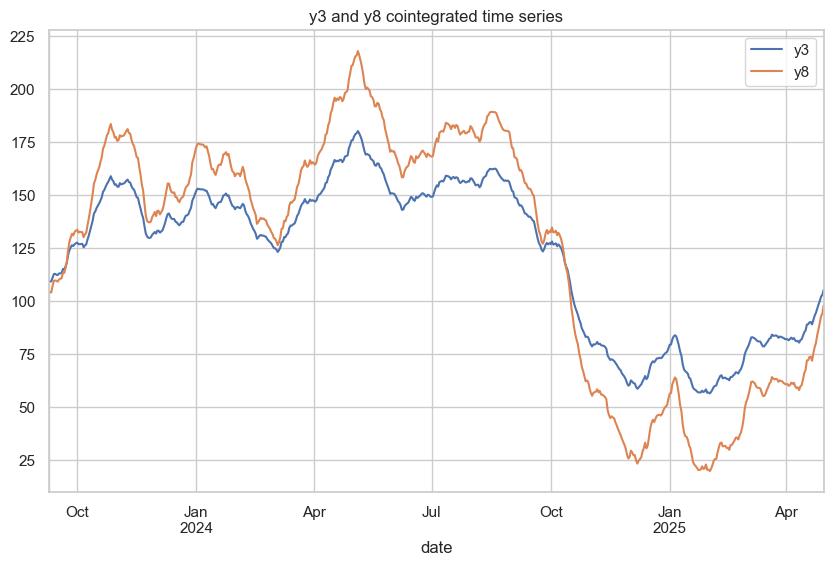

In [22]:
# Plot `y3` and `y8`
df[['y3', 'y8']].plot(figsize=(10, 6), title="y3 and y8 cointegrated time series")
plt.show() #doesn't seem like cointegrated assets

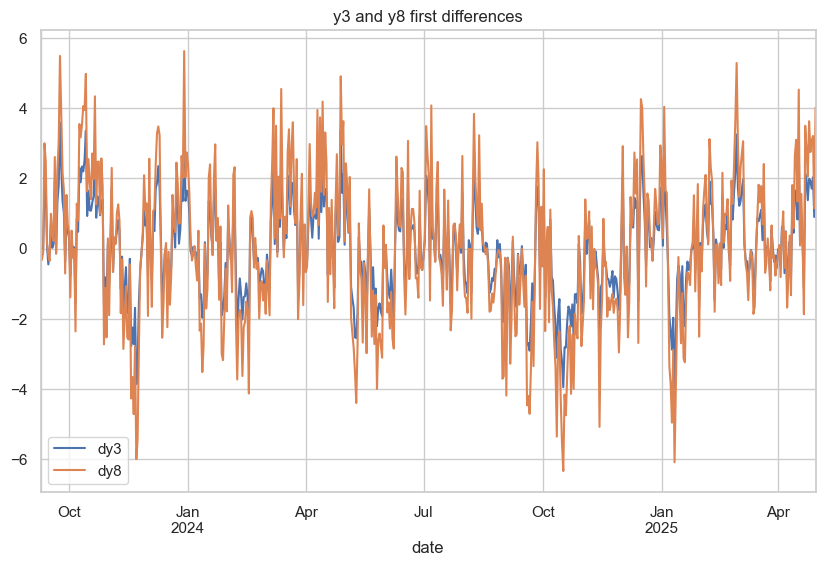

In [23]:
# Plot `dy3` and `dy8`
df[['dy3', 'dy8']].plot(figsize=(10, 6), title="y3 and y8 first differences")
plt.show()

## VECM model

In [24]:
# Granger causality tests
grangercausalitytests(df[['y3', 'y8']].dropna(), maxlag=5) #H0: no granger causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2652  , p=0.6068  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=0.2665  , p=0.6057  , df=1
likelihood ratio test: chi2=0.2665  , p=0.6057  , df=1
parameter F test:         F=0.2652  , p=0.6068  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1452  , p=0.8648  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=0.2929  , p=0.8638  , df=2
likelihood ratio test: chi2=0.2929  , p=0.8638  , df=2
parameter F test:         F=0.1452  , p=0.8648  , df_denom=593, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2834  , p=0.8374  , df_denom=590, df_num=3
ssr based chi2 test:   chi2=0.8603  , p=0.8350  , df=3
likelihood ratio test: chi2=0.8597  , p=0.8351  , df=3
parameter F test:         F=0.2834  , p=0.8374  , df_denom=590, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3042  , p=0.8752  

{1: ({'ssr_ftest': (0.2651941417279656, 0.6067648853736204, 596.0, 1),
   'ssr_chi2test': (0.2665290115688782, 0.6056697020573769, 1),
   'lrtest': (0.26646973222977977, 0.605709797565491, 1),
   'params_ftest': (0.2651941417283818, 0.6067648853733958, 596.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.14524305494456063, 0.8648428262799449, 593.0, 2),
   'ssr_chi2test': (0.2929354025526046, 0.863753630024069, 2),
   'lrtest': (0.2928636775218365, 0.8637846069573658, 2),
   'params_ftest': (0.14524305494489684, 0.8648428262796316, 593.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2834033806660931, 0.8373976755332482, 590.0, 3),
   'ssr_chi2test': (0.8602973809711402, 0.834996821177352, 3),
   'lrtest': (0.8596781168728285, 0.8351458561283455, 3),
   'params_ftest': (0.2834033806651535, 0.8373976755339272, 590.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

In [ ]:
#Result: We fail to reject the null of no causality at the 5% level for each lags. 
#Hence, y3 is not a Granger cause of y8.

In [25]:
# Opposite relation
grangercausalitytests(df[['y8', 'y3']].dropna(), maxlag=5) #H0: no granger causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1901  , p=0.0746  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=3.2061  , p=0.0734  , df=1
likelihood ratio test: chi2=3.1976  , p=0.0737  , df=1
parameter F test:         F=3.1901  , p=0.0746  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.6489 , p=0.0000  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=29.5448 , p=0.0000  , df=2
likelihood ratio test: chi2=28.8381 , p=0.0000  , df=2
parameter F test:         F=14.6489 , p=0.0000  , df_denom=593, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.4039  , p=0.0000  , df_denom=590, df_num=3
ssr based chi2 test:   chi2=25.5109 , p=0.0000  , df=3
likelihood ratio test: chi2=24.9809 , p=0.0000  , df=3
parameter F test:         F=8.4039  , p=0.0000  , df_denom=590, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3137  , p=0.0001  

{1: ({'ssr_ftest': (3.1900512769464537, 0.07459595529033708, 596.0, 1),
   'ssr_chi2test': (3.2061085820317548, 0.07336377524050412, 1),
   'lrtest': (3.197558832508548, 0.07374827436018154, 1),
   'params_ftest': (3.190051276945654, 0.07459595529037737, 596.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (14.648888448299868, 6.169295930797779e-07, 593.0, 2),
   'ssr_chi2test': (29.544807055930256, 3.840843957280361e-07, 2),
   'lrtest': (28.83814346337431, 5.468606983926047e-07, 2),
   'params_ftest': (14.648888448299854, 6.169295930798173e-07, 593.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.403928469987775, 1.7763576856449353e-05, 590.0, 3),
   'ssr_chi2test': (25.510908287708656, 1.2072565937031205e-05, 3),
   'lrtest': (24.980890773446845, 1.558320205384274e-05, 3),
   'params_ftest': (8.403928469988152, 1.7763576856440046e-05, 590.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.

In [ ]:
#Result: We reject the null of no causality at the 5% level for models with 2,3,4 lags. For 1 lag, we fail to reject the null with 5% level and reject with 10% level.
#Hence, y8 is a Granger cause of y3 (but the relationship is not fully certain)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2023-09-09 to 2025-04-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y1      600 non-null    float64
 1   y5      600 non-null    float64
 2   dy1     599 non-null    float64
 3   dy5     599 non-null    float64
 4   lresid  599 non-null    float64
dtypes: float64(5)
memory usage: 28.1 KB


In [29]:
#VAR preliminary model preparation

df_var = df.drop(columns=[col for col in df.columns if col not in ['y3', 'y8']])

# Fit a VAR model to the data
model = VAR(df_var)
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.911       3.926       49.95       3.917
1       -2.731      -2.686     0.06516      -2.713
2       -3.237      -3.163     0.03926      -3.208
3       -3.277     -3.173*     0.03774     -3.236*
4      -3.279*      -3.144    0.03767*      -3.226
5       -3.270      -3.106     0.03799      -3.206
6       -3.262      -3.068     0.03830      -3.187
7       -3.261      -3.036     0.03837      -3.173
8       -3.260      -3.005     0.03841      -3.161
9       -3.252      -2.968     0.03868      -3.142
10      -3.242      -2.928     0.03908      -3.120
11      -3.232      -2.888     0.03949      -3.098
12      -3.220      -2.846     0.03998      -3.074
13      -3.217      -2.813     0.04009      -3.060
14      -3.208      -2.774     0.04046      -3.039
15      -3.208      -2.745     0.04043      -3.028
-------

Information criteria for different lag orders:
  aic bic hqic fpe
1   1   1    1   1
2   2   2    2   2
3   3   3    3   3
4   4   3    3   4
5   4   3    3   4
6   4   3    3   4


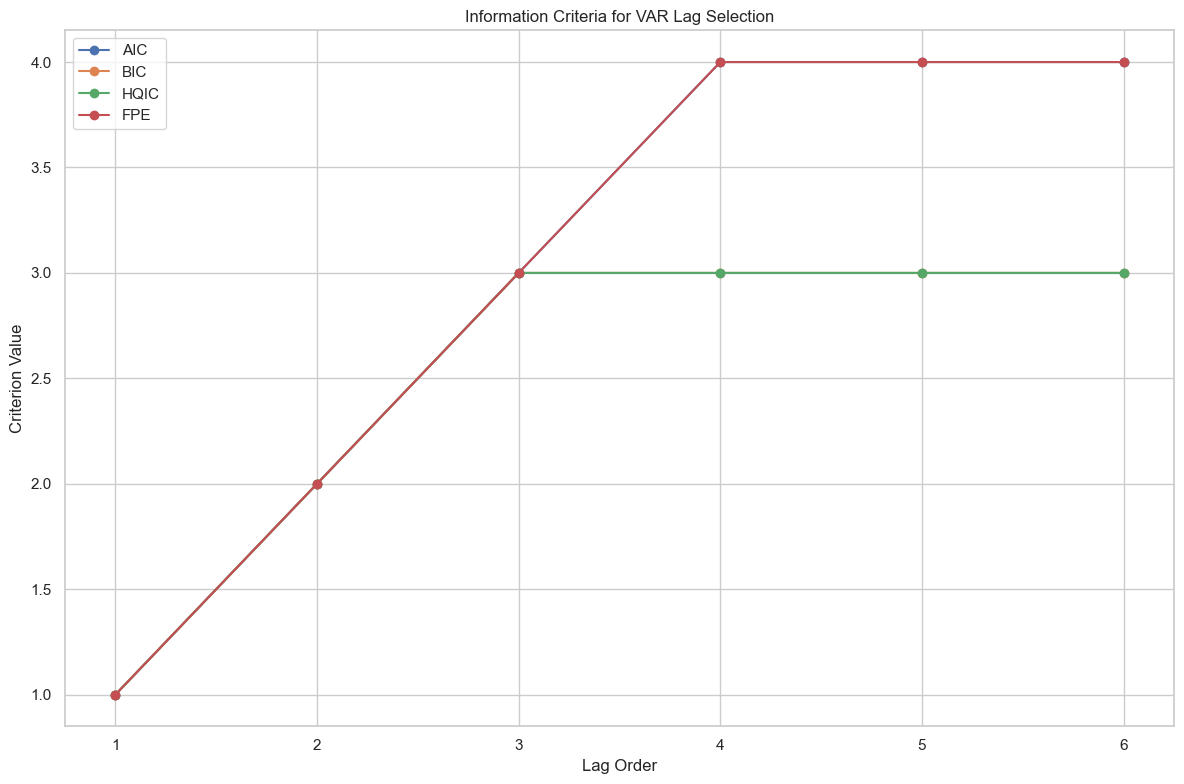

In [27]:
# Function to select optimal lag order
def select_var_order(data, max_lags=12):
    # Create a VAR model
    model = VAR(data)
    
    # Determine information criteria for different lag orders
    results = {}
    for i in range(1, max_lags + 1):
        results[i] = model.select_order(i)
    
    # Create a DataFrame to display the results
    criteria = ['aic', 'bic', 'hqic', 'fpe']
    order_df = pd.DataFrame(index=range(1, max_lags + 1), columns=criteria)
    
    for i in range(1, max_lags + 1):
        for criterion in criteria:
            order_df.loc[i, criterion] = getattr(results[i], criterion)
    
    return order_df

# Select optimal lag order
lag_order_results = select_var_order(df_var, max_lags=6)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Basing on a plot: lag=4

In [19]:
# Fit VAR(4) model
var4_model = VAR(df_var)
var4_results = var4_model.fit(4)

# Print model summary
print(var4_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Jun, 2025
Time:                     09:16:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.14438
Nobs:                     596.000    HQIC:                  -3.22534
Log likelihood:          -696.837    FPE:                  0.0377426
AIC:                     -3.27697    Det(Omega_mle):       0.0366280
--------------------------------------------------------------------
Results for equation y3
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -27.484077        29.700220           -0.925           0.355
L1.y3         1.682579         0.333694            5.042           0.000
L1.y8        -0.130104         0.206474           -0.630           0.529
L2.y3        -0.090190

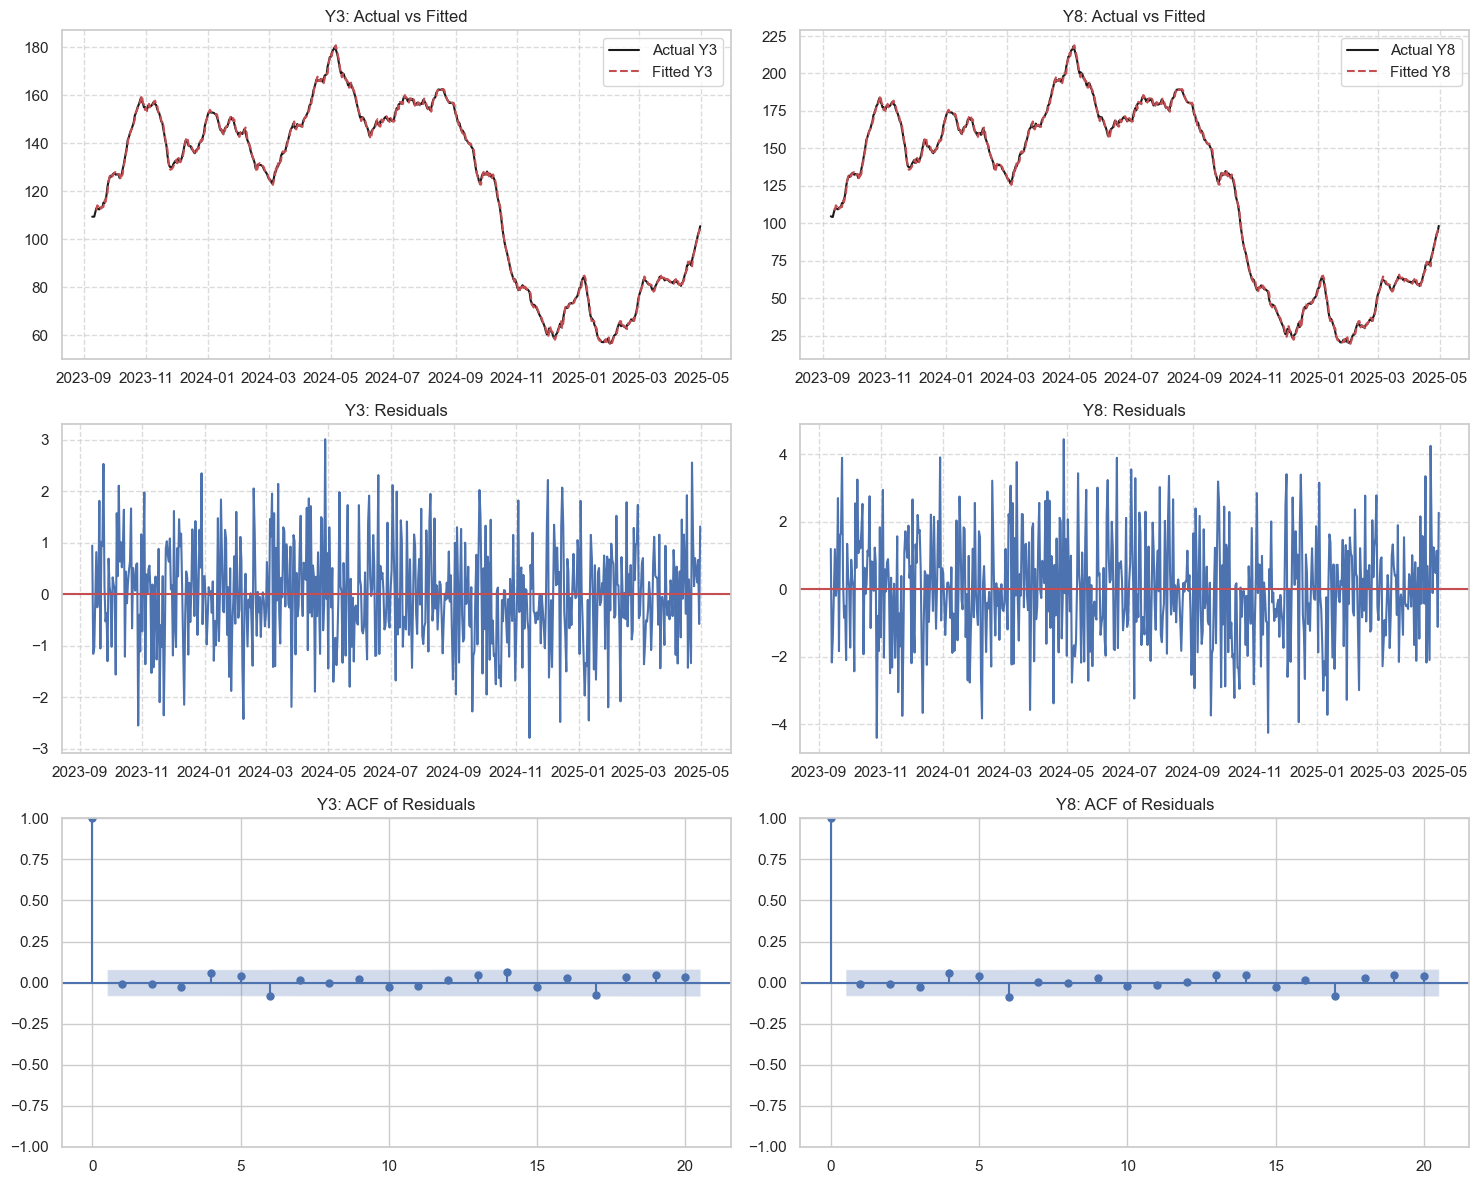

In [29]:
#VAR model diagnostics
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(df_var.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(df_var.index, df_var[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var4_results.fittedvalues[name].index, var4_results.fittedvalues[name], 'r--', 
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(df_var.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var4_results.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(df_var.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var4_results.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show() 

In [30]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var4_results.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

Y3 series:
Lag 12: p-value = 0.7251
Lag 24: p-value = 0.6631

Y8 series:
Lag 12: p-value = 0.7108
Lag 24: p-value = 0.6816


In [ ]:
#Result: no autocorrelation in residuals for each lag and variable, so we can proceed with the model

In [30]:
# Why such a VAR model estimation? For VECM Johansen Cointegration test!
# Perform Johansen test
# K=4 in levels VAR -> k_ar_diff = K-1 = 3 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)

data_for_test = df_var[['y3', 'y8']]
johansen_result = coint_johansen(data_for_test, det_order=0, k_ar_diff=3)

print("Johansen Test Results:")
print("Eigenvalues:")
print(johansen_result.eig)
print("\nTrace Statistic:")
print(johansen_result.lr1)
print("\nCritical Values (90%, 95%, 99%) for Trace Statistic:")
print(johansen_result.cvt)
print("\nMaximum Eigenvalue Statistic:")
print(johansen_result.lr2)
print("\nCritical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:")
print(johansen_result.cvm)

Johansen Test Results:
Eigenvalues:
[0.2167409  0.00275495]

Trace Statistic:
[147.24208802   1.64421543]

Critical Values (90%, 95%, 99%) for Trace Statistic:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Maximum Eigenvalue Statistic:
[145.5978726    1.64421543]

Critical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [32]:
#Automation of Johansen interpretation
print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvm[i, 1]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 147.242
  Critical Value (95%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 1.644
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 145.598
  Critical Value (95%): 14.264
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 1.644
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.


In [ ]:
#Exactly one cointegration vector!

In [33]:
print("Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):")
print(johansen_result.evec)

print("\nCointegrating Vector (beta - first column of eigenvectors):")
coint_vector_raw = johansen_result.evec[:, 0]
print(coint_vector_raw)

# Normalize the first element to 1 for potentially easier interpretation
coint_vector_normalized = coint_vector_raw / coint_vector_raw[0]
print("\nCointegrating Vector (beta, normalized with ppi coefficient = 1):")
print(coint_vector_normalized)

Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):
[[ 16.76156669  -0.11036398]
 [-10.47523735   0.05147766]]

Cointegrating Vector (beta - first column of eigenvectors):
[ 16.76156669 -10.47523735]

Cointegrating Vector (beta, normalized with ppi coefficient = 1):
[ 1.         -0.62495574]


In [31]:
# Estimate VECM
vecm_model = VECM(data_for_test, k_ar_diff=3, coint_rank=1, deterministic='ci')
vecm_results = vecm_model.fit()

In [32]:
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y3
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y3          0.0548      0.578      0.095      0.925      -1.079       1.188
L1.y8          0.2638      0.360      0.733      0.463      -0.441       0.969
L2.y3         -0.0363      0.468     -0.078      0.938      -0.953       0.880
L2.y8          0.1292      0.291      0.444      0.657      -0.441       0.699
L3.y3          0.1083      0.329      0.330      0.742      -0.536       0.752
L3.y8         -0.0068      0.204     -0.033      0.973      -0.408       0.394
Det. terms outside the coint. relation & lagged endog. parameters for equation y8
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y3         -0.0039      0.936     -0.004   

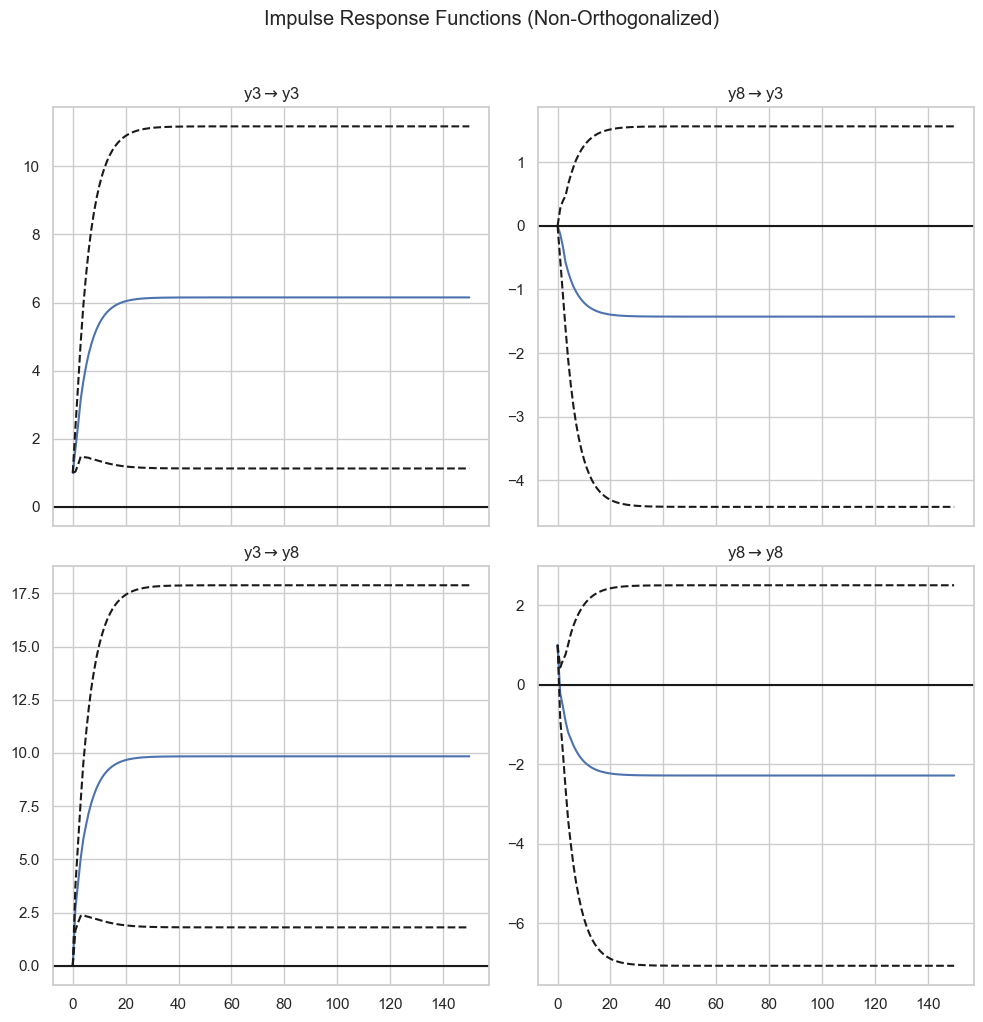

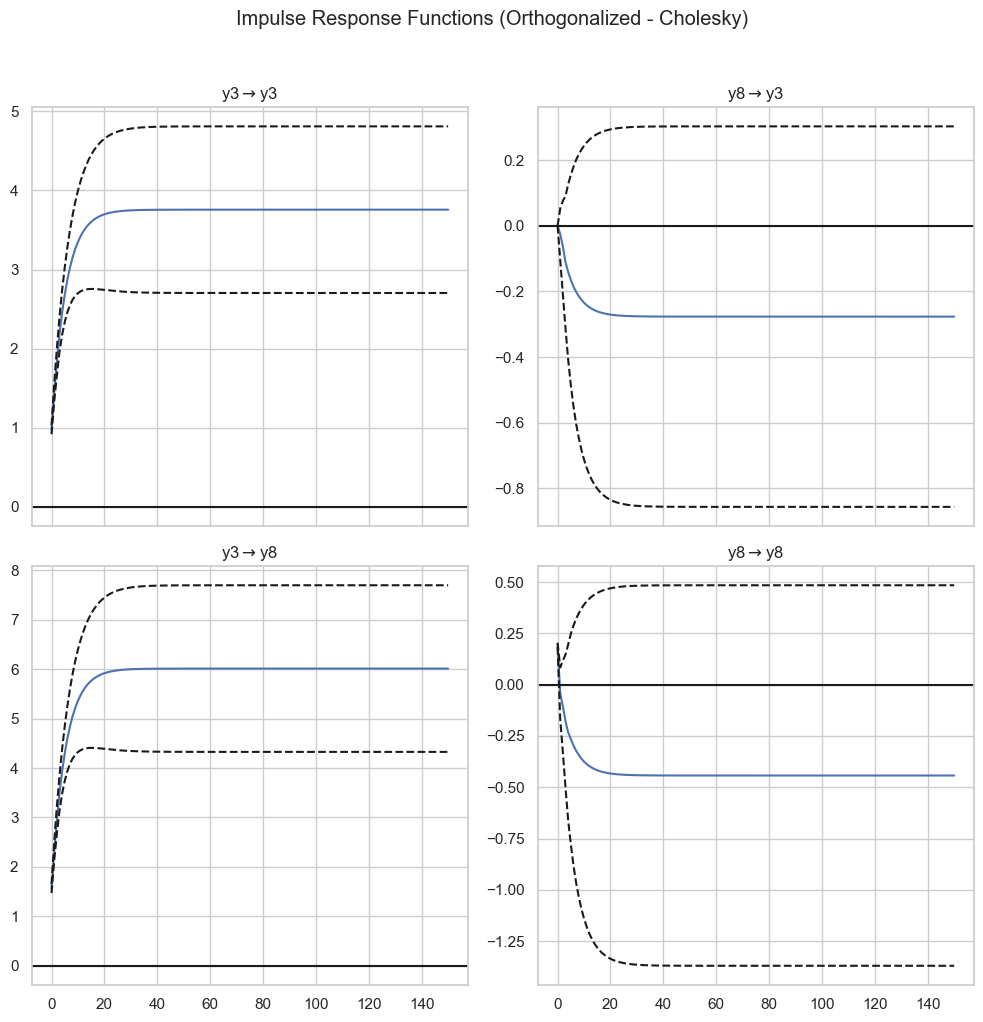

In [36]:
#Interpretation and evaluation
# Calculate and plot IRFs
irf = vecm_results.irf(periods=150) #150 periods ahead, for better visualization of shocks impact

# Non-orthogonalized IRFs
irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
plt.tight_layout()
plt.show()

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

Interpretation

    y3->y3 : initial increase up to 25 days, and afterward slow decrease toward equilibrium
    y3->y8 : shock has bigger initial impact on y8, but as in previous case impacted variable is slowly converging toward 0
    y8->y3 : no first period impact of the y8 on y3. But we can observe negative impact on y3 and which converges back to 0
    y8->y8 : quick small jump at the beginning but as in previous case we are observing negative impact on first periods and convergence starting prior 25 period.

In [37]:
# Estimate VAR
var_model = VAR(data_for_test)
var_results = var_model.fit(4)

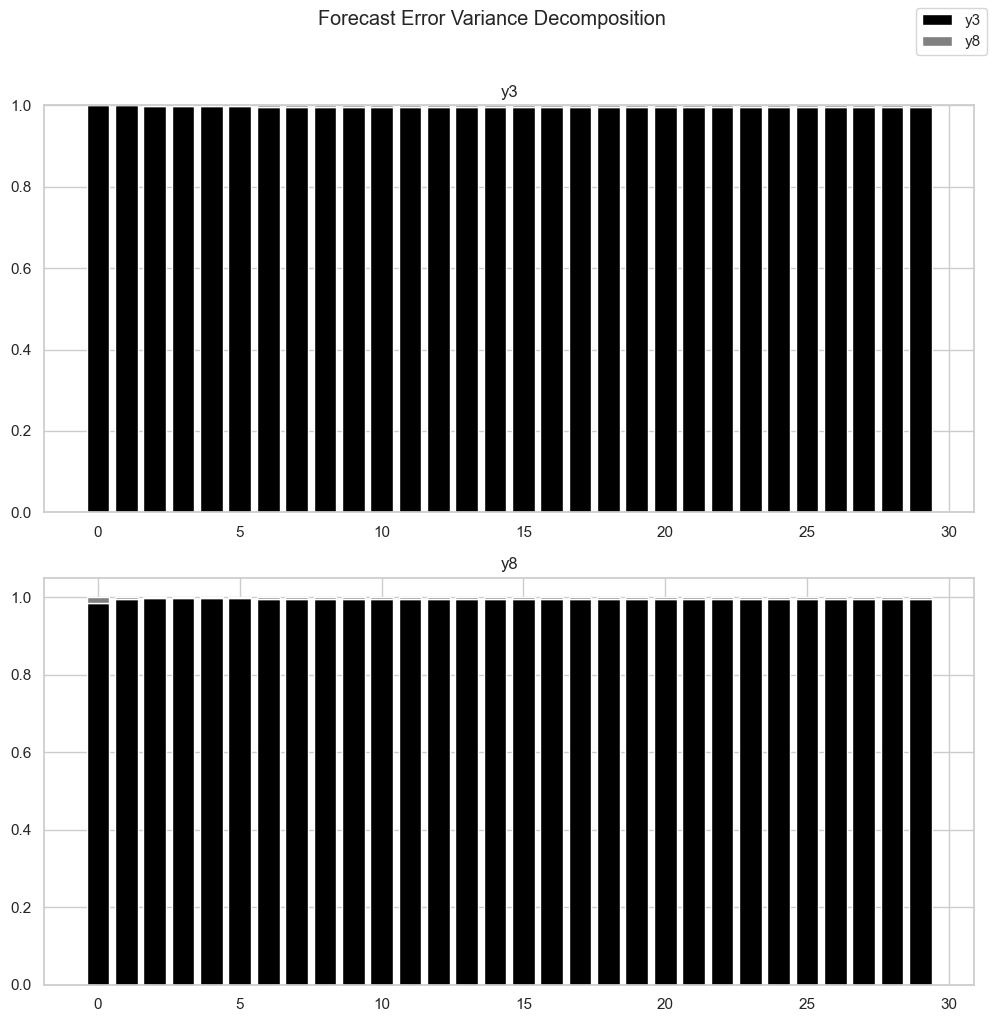


FEVD Summary (Period 30):
FEVD for y3
            y3        y8
0     1.000000  0.000000
1     0.999788  0.000212
2     0.999269  0.000731
3     0.998472  0.001528
4     0.997862  0.002138
5     0.997385  0.002615
6     0.997002  0.002998
7     0.996702  0.003298
8     0.996457  0.003543
9     0.996255  0.003745
10    0.996086  0.003914
11    0.995943  0.004057
12    0.995821  0.004179
13    0.995716  0.004284
14    0.995625  0.004375
15    0.995546  0.004454
16    0.995477  0.004523
17    0.995416  0.004584
18    0.995362  0.004638
19    0.995314  0.004686
20    0.995271  0.004729
21    0.995232  0.004768
22    0.995198  0.004802
23    0.995166  0.004834
24    0.995138  0.004862
25    0.995112  0.004888
26    0.995088  0.004912
27    0.995067  0.004933
28    0.995047  0.004953
29    0.995029  0.004971

FEVD for y8
            y3        y8
0     0.984801  0.015199
1     0.994915  0.005085
2     0.996903  0.003097
3     0.997115  0.002885
4     0.996905  0.003095
5     0.996709  0.00329

In [39]:
# Calculate and plot FEVD
fevd = var_results.fevd(periods=30) 
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
print("\nFEVD Summary (Period 30):")
print(fevd.summary())

We can see that variance of forecast error terms are explained mainly by changes in y3 for both variables. That confirms our main previous observations that shocks in y3 have impact on y8 but not other way around.

In [45]:
residuals = vecm_results.resid
# to DataFrame
residuals = pd.DataFrame(residuals, columns=['y3', 'y8'], index=df.index[4:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y8 = acorr_ljungbox(residuals['y8'], lags=[10], return_df=True)
ljung_box_y3 = acorr_ljungbox(residuals['y3'], lags=[10], return_df=True)
print("\ny8 Residuals:\n", ljung_box_y8)
print("\ny3 Residuals:\n", ljung_box_y3)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y8['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y8 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y8 residuals.")
if ljung_box_y3['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y3 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y3 residuals.")

Residuals (first 5 rows):
                      y3            y8
date                                  
2023-09-13  0.9589545854  1.2168454046
2023-09-14 -1.1447274121 -2.1456542722
2023-09-15 -1.0183648313 -1.4043300837
2023-09-16 -0.0987122791 -0.1039733344
2023-09-17  0.8322826366  1.2067684942

Ljung-Box Test for Serial Correlation in Residuals (lag=10):

y8 Residuals:
         lb_stat    lb_pvalue
10 8.7482746143 0.5561483380

y3 Residuals:
         lb_stat    lb_pvalue
10 8.3462904896 0.5950514178

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for y8 residuals.
 - Cannot reject H0 (no serial correlation) for y3 residuals.


In [62]:
# Create shorter sample (excluding last 25 observations)
n_forecast = 25
df_short = data_for_test.iloc[:-n_forecast]
df_actual = data_for_test.iloc[-n_forecast:]
print("Last few rows of shorter sample:")
print(df_short.tail())
print("\nActual values for forecast period:")
print(df_actual.head())

Last few rows of shorter sample:
                      y3            y8
date                                  
2025-04-01 82.2000000000 60.9000000000
2025-04-02 82.1600000000 61.0000000000
2025-04-03 81.6600000000 60.1900000000
2025-04-04 82.2800000000 60.6200000000
2025-04-05 82.9000000000 61.6800000000

Actual values for forecast period:
                      y3            y8
date                                  
2025-04-06 82.2000000000 61.1300000000
2025-04-07 82.6900000000 61.6000000000
2025-04-08 81.5900000000 59.9200000000
2025-04-09 81.1900000000 59.1000000000
2025-04-10 81.3900000000 59.4700000000


In [47]:
# Re-run Johansen test on shorter sample
johansen_result_short = coint_johansen(df_short, det_order=0, k_ar_diff=3)

print("\nJohansen Test on Shorter Sample (Trace Statistic):")
print("Trace Statistic:", johansen_result_short.lr1)
print("Critical Values (95%):", johansen_result_short.cvt[:, 1])

# Determine rank based on test
rank_short = 0
for i in range(len(johansen_result_short.lr1)):
    if johansen_result_short.lr1[i] > johansen_result_short.cvt[i, 1]:
        rank_short = i + 1
    else:
        break
print(f"--> Determined Cointegration Rank on shorter sample: r = {rank_short}")

# Assuming rank is still 1 based on R output/consistency, proceed with r=1
rank_short = 1 # Override if necessary based on re-evaluation
print(f"Proceeding with rank r = {rank_short} for forecasting model.")


Johansen Test on Shorter Sample (Trace Statistic):
Trace Statistic: [140.03017504   0.9990293 ]
Critical Values (95%): [15.4943  3.8415]
--> Determined Cointegration Rank on shorter sample: r = 1
Proceeding with rank r = 1 for forecasting model.


In [48]:
# Re-estimate VECM on shorter sample
vecm_model_short = VECM(df_short, k_ar_diff=3, coint_rank=rank_short, deterministic='ci')
vecm_results_short = vecm_model_short.fit()

# Generate forecasts
forecast_values = vecm_results_short.predict(steps=n_forecast)
forecast_intervals = vecm_results_short.predict(steps=n_forecast, alpha=0.05) # alpha=0.05 for 95% CI

# Create forecast DataFrame
forecast_index = df_actual.index
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['y3_fore', 'y8_fore'])

In [46]:
print(forecast_df)

                 y3_fore       y8_fore
date                                  
2025-04-06 83.3082495595 62.6769872195
2025-04-07 83.7391468968 63.3437800777
2025-04-08 84.0974818396 63.9217376155
2025-04-09 84.3665307589 64.3526491109
2025-04-10 84.5904793081 64.6977285164
2025-04-11 84.7721969023 64.9887293975
2025-04-12 84.9194421083 65.2249508392
2025-04-13 85.0406062505 65.4186355758
2025-04-14 85.1394795757 65.5771775436
2025-04-15 85.2201425762 65.7062033822
2025-04-16 85.2860357426 65.8115338884
2025-04-17 85.3397957823 65.8975159187
2025-04-18 85.3836759509 65.9676846058
2025-04-19 85.4194993522 66.0249764011
2025-04-20 85.4487407077 66.0717456196
2025-04-21 85.4726111119 66.1099224577
2025-04-22 85.4920968891 66.1410868578
2025-04-23 85.5080029981 66.1665260877
2025-04-24 85.5209872110 66.1872920597
2025-04-25 85.5315862477 66.2042434258
2025-04-26 85.5402382515 66.2180808549
2025-04-27 85.5473009078 66.2293763862
2025-04-28 85.5530661708 66.2385969600
2025-04-29 85.5577723678 

In [49]:
# Create forecast interval DataFrames
forecast_lower = pd.DataFrame(forecast_intervals[1], index=forecast_index, columns=['y3_lower', 'y8_lower'])
forecast_upper = pd.DataFrame(forecast_intervals[2], index=forecast_index, columns=['y3_upper', 'y8_upper'])

# Combine forecasts and intervals
forecast_combined = pd.concat([forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined)


Forecasts and Confidence Intervals:
                 y3_fore       y8_fore      y3_lower      y8_lower       y3_upper       y8_upper
date                                                                                            
2025-04-06 83.3082495596 62.6769872197 81.4080712495 59.6026582593  85.2084278696  65.7513161801
2025-04-07 83.7391468969 63.3437800782 80.3284385059 57.8605976982  87.1498552880  68.8269624583
2025-04-08 84.0974818399 63.9217376163 79.1496340863 55.9595762145  89.0453295934  71.8838990181
2025-04-09 84.3665307592 64.3526491115 77.8329045662 53.8703313257  90.9001569522  74.8349668974
2025-04-10 84.5904793083 64.6977285167 76.4831906606 51.7019041319  92.6977679561  77.6935529015
2025-04-11 84.7721969024 64.9887293978 75.1228573361 49.5275855137  94.4215364688  80.4498732818
2025-04-12 84.9194421085 65.2249508394 73.7671040727 47.3618183277  96.0717801442  83.0880833511
2025-04-13 85.0406062506 65.4186355760 72.4318347978 45.2264715184  97.6493777034  85.6107

In [49]:
df_var.head()

,y3,y8
date,,
2023-09-09,109.4100000000,104.6600000000
2023-09-10,109.4100000000,104.3400000000
2023-09-11,109.4100000000,104.2300000000
2023-09-12,111.1200000000,107.2300000000
2023-09-13,112.9200000000,109.7100000000


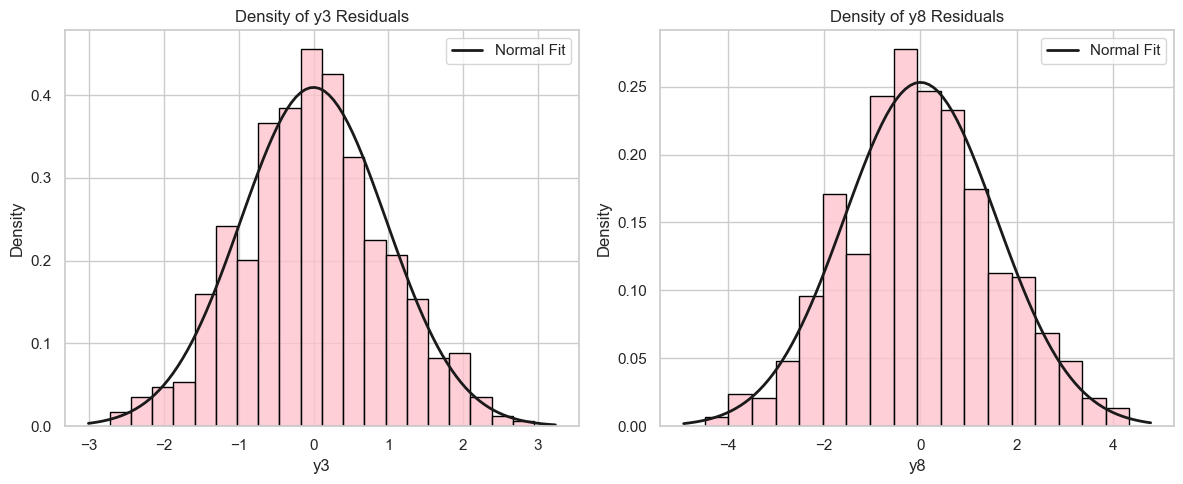

In [50]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['y3'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of y3 Residuals')
# Overlay normal distribution
mu_y3, std_y3 = residuals['y3'].mean(), residuals['y3'].std()
xmin_y3, xmax_y3 = axes[0].get_xlim()
x_y3 = np.linspace(xmin_y3, xmax_y3, 100)
p_y3 = norm.pdf(x_y3, mu_y3, std_y3)
axes[0].plot(x_y3, p_y3, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y8'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y8 Residuals')
# Overlay normal distribution
mu_y8, std_y8 = residuals['y8'].mean(), residuals['y8'].std()
xmin_y8, xmax_y8 = axes[1].get_xlim()
x_y8 = np.linspace(xmin_y8, xmax_y8, 100)
p_y8 = norm.pdf(x_y8, mu_y8, std_y8)
axes[1].plot(x_y8, p_y8, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

In [51]:
# Test for normality (Jarque-Bera test)
jb_y3_stat, jb_y3_pval, _, _ = jarque_bera(residuals['y3'])
jb_y8_stat, jb_y8_pval, _, _ = jarque_bera(residuals['y8'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"y3 Residuals: Statistic={jb_y3_stat:.3f}, p-value={jb_y3_pval:.3f}")
print(f"y8 Residuals: Statistic={jb_y8_stat:.3f}, p-value={jb_y8_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_y3_pval < alpha_norm:
    print(" - Reject normality for y3 residuals.")
else:
    print(" - Cannot reject normality for y3 residuals.")
if jb_y8_pval < alpha_norm:
    print(" - Reject normality for y8 residuals.")
else:
    print(" - Cannot reject normality for y8 residuals.")

# Multivariate Normality Test (using VECM Results method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECM Results method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")


Jarque-Bera Normality Test for Residuals:
y3 Residuals: Statistic=0.656, p-value=0.720
y8 Residuals: Statistic=1.045, p-value=0.593

Conclusion at alpha=0.05:
 - Cannot reject normality for y3 residuals.
 - Cannot reject normality for y8 residuals.

Multivariate Normality Test Results (using VECM Results method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 1.990, critical value: 9.488>, p-value: 0.738>


Result: basing on a graph and on Jarque-Bera test we can conclude that residuals don't come from standard normal distribution (some level of assymetry).

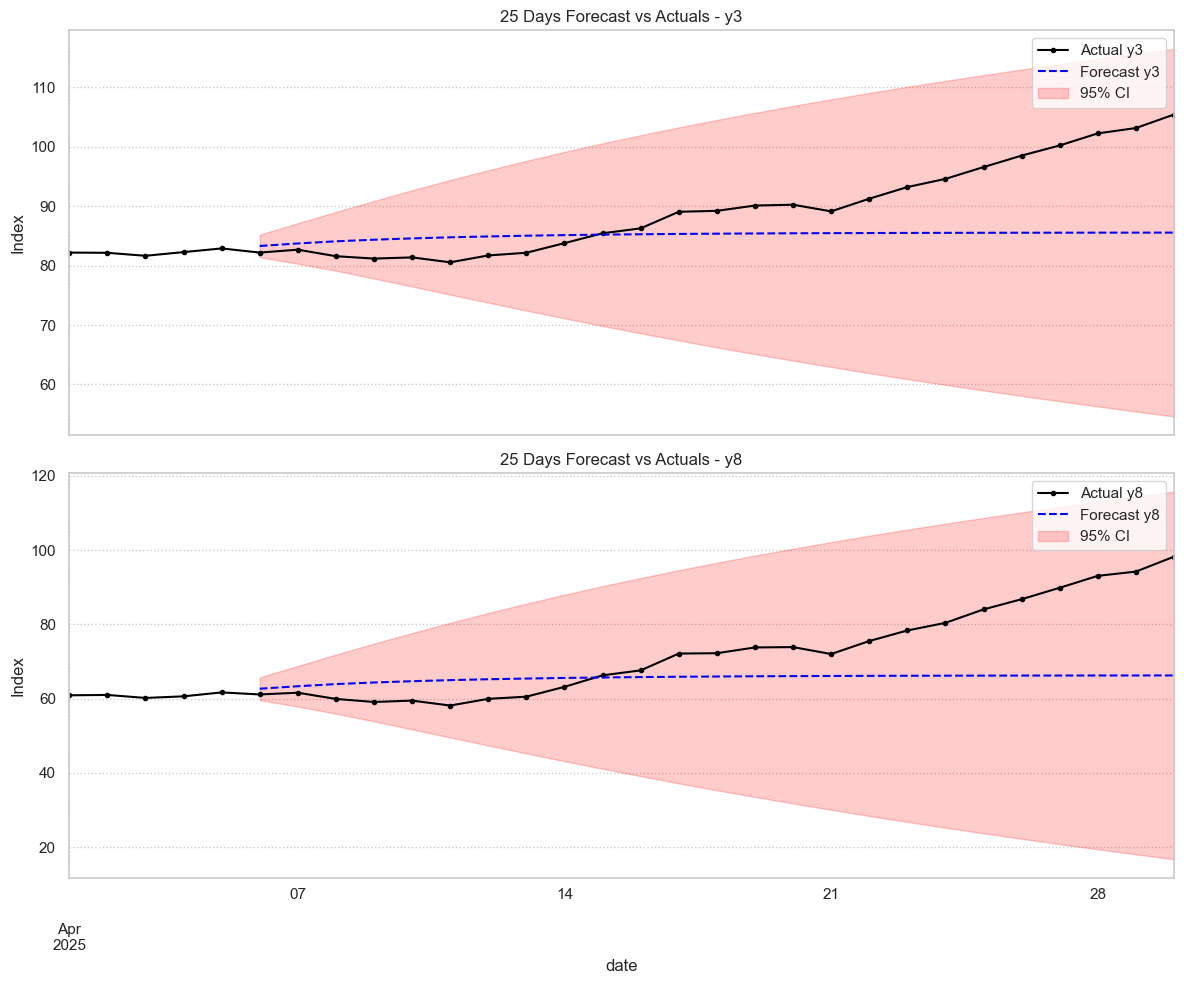

In [52]:
# Merge forecasts with the original data for plotting
df_merged = df_var.merge(forecast_combined, left_index=True, right_index=True, how='left')

# Plot forecasts vs actuals
plot_start_date = '2025-04-01' # Start date for the plot window

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# y3 Plot
df_merged.loc[plot_start_date:, 'y3'].plot(ax=axes[0], label='Actual y3', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y3_fore'].plot(ax=axes[0], label='Forecast y3', color='blue', linestyle='--')
axes[0].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y3_lower'],
                     df_merged.loc[plot_start_date:, 'y3_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('25 Days Forecast vs Actuals - y3')
axes[0].set_ylabel('Index')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# y5 Plot
df_merged.loc[plot_start_date:, 'y8'].plot(ax=axes[1], label='Actual y8', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y8_fore'].plot(ax=axes[1], label='Forecast y8', color='blue', linestyle='--')
axes[1].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y8_lower'],
                     df_merged.loc[plot_start_date:, 'y8_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('25 Days Forecast vs Actuals - y8')
axes[1].set_ylabel('Index')
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

In [60]:
# Combine forecasts and intervals
forecast_combined = pd.concat([forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined)


Forecasts and Confidence Intervals:
                 y3_fore       y8_fore      y3_lower      y8_lower       y3_upper       y8_upper
date                                                                                            
2025-04-06 83.3082495596 62.6769872197 81.4080712495 59.6026582593  85.2084278696  65.7513161801
2025-04-07 83.7391468969 63.3437800782 80.3284385059 57.8605976982  87.1498552880  68.8269624583
2025-04-08 84.0974818399 63.9217376163 79.1496340863 55.9595762145  89.0453295934  71.8838990181
2025-04-09 84.3665307592 64.3526491115 77.8329045662 53.8703313257  90.9001569522  74.8349668974
2025-04-10 84.5904793083 64.6977285167 76.4831906606 51.7019041319  92.6977679561  77.6935529015
2025-04-11 84.7721969024 64.9887293978 75.1228573361 49.5275855137  94.4215364688  80.4498732818
2025-04-12 84.9194421085 65.2249508394 73.7671040727 47.3618183277  96.0717801442  83.0880833511
2025-04-13 85.0406062506 65.4186355760 72.4318347978 45.2264715184  97.6493777034  85.6107

In [73]:
# Generate confidence intervals using the forecast error covariance
# This is a simplification as statsmodels doesn't directly provide confidence intervals

df = df[['y3', 'y8']]

def compute_forecast_ci(model_results, y_values, steps, alpha=0.05):
    """Compute confidence intervals for VAR forecasts"""
    forecast_mean = model_results.forecast(y_values, steps)
    
    # Get forecast error covariance matrix for h-step ahead forecasts
    mse = np.zeros((steps, model_results.neqs, model_results.neqs))
    for i in range(steps):
        mse[i] = model_results.forecast_cov(i+1)[-1] #do zmiany !!!
    
    # Compute standard errors for each forecast
    stderr = np.zeros((steps, model_results.neqs))
    for i in range(steps):
        stderr[i] = np.sqrt(np.diag(mse[i]))
    
    # Compute confidence intervals
    from scipy.stats import norm
    q = norm.ppf(1 - alpha/2)
    lower = forecast_mean - q * stderr
    upper = forecast_mean + q * stderr
    
    return forecast_mean, lower, upper

# Calculate forecast means and 95% confidence intervals
forecast_mean, forecast_lower, forecast_upper = compute_forecast_ci(
    var_results, df_short.values, forecast_horizon, alpha=0.05
)

# Create DataFrames for the confidence intervals
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index, 
                               columns=[f"{col}_lower" for col in df_short.columns])
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index, 
                               columns=[f"{col}_upper" for col in df_short.columns])

# Combine the forecasts and actual values
forecast_evaluation = pd.concat([
    df.loc[forecast_index],
    forecast_df,
    forecast_lower_df,
    forecast_upper_df
], axis=1)

forecast_evaluation.columns = [
    'y3_actual', 'y8_actual', 
    'y3_forecast', 'y8_forecast',
    'y3_lower', 'y8_lower',
    'y3_upper', 'y8_upper'
]

print("Forecast evaluation dataset:")
print(forecast_evaluation)


Forecast evaluation dataset:
                y3_actual     y8_actual   y3_forecast   y8_forecast      y3_lower      y8_lower       y3_upper       y8_upper
date                                                                                                                         
2025-04-06  82.2000000000 61.1300000000 83.3082495596 62.6769872197 81.4557230349 59.6727539802  85.2957084363  65.8846098121
2025-04-07  82.6900000000 61.6000000000 83.7391468969 63.3437800782 80.4972350776 58.1303694485  87.3368512653  69.1201589319
2025-04-08  81.5900000000 59.9200000000 84.0974818399 63.9217376163 79.4517370049 56.4483525809  89.3637521484  72.3942245049
2025-04-09  81.1900000000 59.1000000000 84.3665307592 64.3526491115 78.2745734670 54.5800146467  91.3785453978  75.6059865966
2025-04-10  81.3900000000 59.4700000000 84.5904793083 64.6977285167 77.0735025277 52.6464676469  93.3508297342  78.7438606396
2025-04-11  80.5600000000 58.1400000000 84.7721969024 64.9887293978 75.8683197640 50.7195

In [74]:
# Calculate forecast accuracy measures

# Define the function for MAPE and AMAPE
def mape(actual, pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / actual)) * 100

def amape(actual, pred):
    """Adjusted/Symmetric Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / ((actual + pred) / 2))) * 100

# Calculate metrics for y3
y3_mae = mean_absolute_error(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])
y3_mse = mean_squared_error(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])
y3_rmse = np.sqrt(y3_mse)
y3_mape = mape(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])
y3_amape = amape(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])

# Calculate metrics for y8
y8_mae = mean_absolute_error(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])
y8_mse = mean_squared_error(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])
y8_rmse = np.sqrt(y8_mse)
y8_mape = mape(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])
y8_amape = amape(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'y3': [y3_mae, y3_mse, y3_rmse, y3_mape, y3_amape],
    'y8': [y8_mae, y8_mse, y8_rmse, y8_mape, y8_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df)

Forecast Accuracy Metrics:
                     y3             y8
MAE        6.4084178754  10.3335679762
MSE       72.9347760016 187.5732073233
RMSE       8.5401859465  13.6957368302
MAPE (%)   6.7263786810  12.8179570496
AMAPE (%)  7.0829788689  14.0116509645


In [ ]:
#We can see that model that predicts "y3" values is more accurate comparing to model predicting "y8"